In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import pickle
import random
random.seed(1)
from math import *

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

In [2]:
plt.rcParams["figure.figsize"] = (15,5)

In [3]:
marker_genes = pickle.load(open("../../CAR_data/marker_genes", "rb"))

In [4]:
TFs = pickle.load(open("../../CAR_data/TF_list", "rb"))
upstream_nodes_dict = pickle.load(open("../../CAR_data/upstream_node_dict", "rb"))
# Remove AP1 as we don't have its expression

# Sanity check: predict cell function from downstream gene expression

## Find out which genes are the downstream genes of the GRN

In [5]:
import networkx as nx

In [6]:
# The network with the GRN
df = pd.read_csv('../../CAR_data/Network_with_GRN.tsv', sep = "\t", header=None)
df.columns = ["source", "target", "weight"]
Graphtype = nx.DiGraph()
G_GRN= nx.from_pandas_edgelist(df, create_using=Graphtype)
#nx.draw(G_GRN)

In [7]:
# The manual network (without GRN)
df = pd.read_csv('../../CAR_data/Network_without_GRN.tsv', sep = "\t", header=None)
df.columns = ["source", "target", "weight"]
Graphtype = nx.DiGraph()
G_noGRN = nx.from_pandas_edgelist(df, create_using=Graphtype)

# Collect all the nodes that are downstream of the network and don't have any output nodes
TF_manual_network = []
outdegree = G_noGRN.out_degree
for node in G_noGRN.nodes:
    if outdegree(node) == 0:
        TF_manual_network.append(node)
TF_manual_network.sort()

In [8]:
[k for k in G_GRN.edges() if "mTOR" == k[1]]

[('Akt', 'mTOR')]

In [9]:
print([(key, val) for key,val in upstream_nodes_dict.items()])

[('ATF1', ['CD3z', 'MAPK', 'p38']), ('ATF2', ['ERK12', 'p38']), ('BCL3', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('CEBPB', ['ERK12', 'p38']), ('CEBPZ', ['CD3z', 'MAPK', 'p38']), ('E2F4', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('ELK1', ['ERK12', 'p38']), ('ELK4', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('ESR1', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('ETS1', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('FOS', ['BCL3', 'E2F4', 'ELK4', 'ERK12', 'ETS1', 'FOSL2', 'GABPA', 'JUN', 'MEF2A', 'MYC', 'NANOG', 'RELA', 'SP1']), ('FOSL1', ['CD3z', 'MAPK', 'p38']), ('FOSL2', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('GABPA', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('GATA1', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('GATA2', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('HSF1', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('IRF3', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('JUN', ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']), ('JUND', ['CD3z', 'MAPK', 'p38']), ('MEF2A', ['CD3z

In [10]:
#genes = pickle.load(open("../../CAR_data/genes_list", "rb"))

## Define the nodes we will use as predictors

Nodes are chosen as the immediate parent of the transcription factor. If a node has one parent node, we also use its grandparents. If a node has a complex (for which we don't have the expression) as a parent: we remove the complex and add its parent nodes to the set of predictors. If there is a complex in the grandparent nodes, we remove it.

In [11]:
## Create a dictionary that to each transcription factor associates its directly upstream nodes
upstream_nodes_dict = { tf : list(G_GRN.predecessors(tf)) for tf in TFs}

# The complexes for which we don't have any expression data
comp_list = ["AP1", "NFkB", "TRAF12", "TRAF23", "STAT35"]

## Remove the complexes from the predictors and replace them by their parent
for tf in upstream_nodes_dict:
    parents = upstream_nodes_dict[tf]
    for cplx in comp_list:
        if cplx in parents:
            parents.remove(cplx)
            parents += list(G_GRN.predecessors(cplx))
        # If there is only one parent, then add the grandparents
    if len(parents)==1:
        parents += list(G_GRN.predecessors(parents[0]))
    # If one of the grandparents is a complex still, we remove it
    for cplx in comp_list:
        if cplx in parents:
            parents.remove(cplx)
    parents = list(np.unique(np.asarray(parents)))
    upstream_nodes_dict[tf] = parents

In [12]:
[e for e in G_GRN.edges() if "STAT3" in e]

[('ERK12', 'STAT3'),
 ('STAT3', 'STAT35'),
 ('STAT3', 'CTLA4'),
 ('STAT3', 'LAG3'),
 ('STAT3', 'GZMB'),
 ('STAT3', 'ZNF683'),
 ('STAT3', 'PRDM1'),
 ('STAT3', 'IRF4'),
 ('STAT3', 'PDCD1'),
 ('STAT3', 'IL1A'),
 ('STAT3', 'CCL20'),
 ('STAT3', 'ZEB2'),
 ('STAT3', 'CSF2'),
 ('STAT3', 'CCL3'),
 ('STAT3', 'LIF'),
 ('STAT3', 'TBX21'),
 ('STAT3', 'IFNG'),
 ('STAT3', 'HOPX'),
 ('STAT3', 'IL10'),
 ('STAT3', 'CDK1'),
 ('STAT3', 'CCNA2'),
 ('STAT3', 'BATF3'),
 ('STAT3', 'MKI67'),
 ('STAT3', 'IL1B'),
 ('STAT3', 'NCR1'),
 ('STAT3', 'BATF'),
 ('STAT3', 'ICOS'),
 ('STAT3', 'CD69'),
 ('STAT3', 'CCL1'),
 ('STAT3', 'ID2'),
 ('STAT3', 'ORC6'),
 ('STAT3', 'CCL4'),
 ('STAT3', 'CD244'),
 ('STAT3', 'GZMK'),
 ('STAT3', 'LEF1'),
 ('STAT3', 'AP1'),
 ('STAT3', 'CDCA2'),
 ('STAT3', 'TIGIT'),
 ('STAT3', 'CCL5'),
 ('STAT3', 'FOXP1'),
 ('STAT3', 'STAT1'),
 ('STAT3', 'HAVCR1'),
 ('STAT3', 'LAYN'),
 ('STAT3', 'IL7R'),
 ('STAT3', 'NKG7'),
 ('STAT3', 'TCF7'),
 ('STAT3', 'HAVCR2'),
 ('STAT3', 'G0S2'),
 ('STAT3', 'CXCL8'),


In [13]:
# For each different vector, get the associated class vector
def encode_cell_function(cell_function, cell_functions_list):
    return(cell_functions_list.index(cell_function))

# DEPRECATED
## Let us see how much data we need to impute

NANOG and GATA1 are not considered as they are always 0

In [14]:
# Remove NANOG and GATA1
if "NANOG" in genes:
    genes.remove("NANOG")
if "GATA1" in genes:
    genes.remove("GATA1")

# Count how many dropouts I have per row
series_zero = []
for i in expression_sc.index:
    n_zeros = 0
    for c in genes:
        if expression_sc.loc[i,c] == 0:
            n_zeros +=1
    series_zero.append(n_zeros)
expression_sc["zeros"] = series_zero
    
genes += ["NANOG", "GATA1"]

NameError: name 'genes' is not defined

In [ ]:
expression_sc==0

In [ ]:
zeros = expression_sc==0
zeros = zeros.sum()
m = len(expression_sc)/2
c = 0
for col in zeros.index:
    if zeros[col]>m:
        print(f"{col} : {zeros[col]}")
        c+=1
print(c)

# I think the marker genes are left ono-imputed for some reason

# Predict TF expression from (grand)parent node expression

## Load the data

In [16]:
## Load the single cell data
## We use the imputed data
## We use the log data
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes_with_noise.csv", index_col=0 )

# We can return the data to non-log data
#expression_sc[genes].applymap(lambda x: exp(x)-1)


In [17]:
expression_sc

CD28      PI3K       Lck      Grb2      GADS  \
AAACGAAAGGTAAGGA-1-1    0.934270  0.646465  2.034011  1.544655  0.643488   
AAACGAAGTACGCGTC-1-1    0.000000  0.000000  0.000000  3.325603  0.733718   
AAACGCTGTGTTCCAA-1-1    0.000000  0.000000  1.009158  1.443629  0.247230   
AAAGAACGTTACCTTT-1-1    0.000000  0.000000  0.375234  0.310217  2.427178   
AAAGGATAGTCTTCCC-1-1    0.082061  0.000000  0.205222  0.351251  0.917048   
...                          ...       ...       ...       ...       ...   
TTGTTGTTCCTAGCCT-1-TCR  0.000000  0.389465  2.828681  0.707203  0.730570   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000  1.103013  0.000000  0.000000   
TTTACCAGTCTGTGAT-1-TCR  0.000000  2.420301  0.000000  1.186512  0.000000   
TTTACGTTCACTTTGT-1-TCR  0.071406  0.000000  2.273666  1.702385  1.135095   
TTTCGATTCACCTTGC-1-TCR  0.000000  1.549550  1.556240  2.624107  0.000000   

                             Akt     ERK12     GSK3b      CD3z     PLCg1  ...  \
AAACGAAAGGTAAGGA-1-1    1.078617  0.000000  0.537178  2.948842  0.000000  ...   
AAACGAAGTACGCGTC-1-1    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
AAACGCTGTGTTCCAA-1-1    0.606591  0.038880  0.000000  1.322050  0.360203  ...   
AAAGAACGTTACCTTT-1-1    0.000000  0.576658  1.550084  2.700770  1.581506  ...   
AAAGGATAGTCTTCCC-1-1    0.000000  0.410729  0.000000  3.091313  0.350137  ...   
...                          ...       ...       ...       ...       ...  ...   
TTGTTGTTCCTAGCCT-1-TCR  0.000000  0.358421  0.000000  1.344320  0.000000  ...   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000  2.106083  3.200188  2.073958  ...   
TTTACCAGTCTGTGAT-1-TCR  0.000000  1.695048  0.000000  0.896795  1.494544  ...   
TTTACGTTCACTTTGT-1-TCR  0.000000  1.796472  0.421048  0.789918  0.653082  ...   
TTTCGATTCACCTTGC-1-TCR  0.000000  2.096060  0.861468  3.982394  0.000000  ...   

                        ADORA2A   TNFRSF4  KIR3DL1      GZMA      CD3E  \
AAACGAAAGGTAAGGA-1-1        0.0  0.000000      0.0  0.763259  0.015883   
AAACGAAGTACGCGTC-1-1        0.0  1.848422      0.0  1.236576  0.391389   
AAACGCTGTGTTCCAA-1-1        0.0  0.000000      0.0  0.000000  3.381723   
AAAGAACGTTACCTTT-1-1        0.0  0.000000      0.0  2.411592  0.729270   
AAAGGATAGTCTTCCC-1-1        0.0  0.000000      0.0  0.487836  1.431770   
...                         ...       ...      ...       ...       ...   
TTGTTGTTCCTAGCCT-1-TCR      0.0  0.000000      0.0  1.725796  1.085018   
TTGTTTGTCTATGCCC-1-TCR      0.0  0.000000      0.0  3.895711  4.197764   
TTTACCAGTCTGTGAT-1-TCR      0.0  0.029884      0.0  2.316565  4.303189   
TTTACGTTCACTTTGT-1-TCR      0.0  0.000000      0.0  0.406651  0.759914   
TTTCGATTCACCTTGC-1-TCR      0.0  0.000000      0.0  0.000000  1.872302   

                            RELA      IL16      CAR_Variant  Type  \
AAACGAAAGGTAAGGA-1-1    0.201987  0.694483    h4-1BB_h4-1BB   CD8   
AAACGAAGTACGCGTC-1-1    0.000000  3.192283   h4-1BB_hIL15RA   CD8   
AAACGCTGTGTTCCAA-1-1    0.766144  0.277721    hIL15RA_hCD28   CD4   
AAAGAACGTTACCTTT-1-1    1.772661  0.301632  hIL15RA_hCTLA-4   CD8   
AAAGGATAGTCTTCCC-1-1    0.752401  1.835512    hCTLA-4_hCD40   CD4   
...                          ...       ...              ...   ...   
TTGTTGTTCCTAGCCT-1-TCR  0.597416  0.000000             TCR-   CD8   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000             TCR-   CD8   
TTTACCAGTCTGTGAT-1-TCR  0.000000  0.000000             TCR-   CD4   
TTTACGTTCACTTTGT-1-TCR  0.260466  0.115939             TCR-   CD8   
TTTCGATTCACCTTGC-1-TCR  1.220669  0.562175             TCR-   CD4   

                                   cell_type  
AAACGAAAGGTAAGGA-1-1        CD8 Cytox/Memory  
AAACGAAGTACGCGTC-1-1          CD8 Effector A  
AAACGCTGTGTTCCAA-1-1           CD4 activated  
AAAGAACGTTACCTTT-1-1    CD8 Effector HLAhigh  
AAAGGATAGTCTTCCC-1-1           CD4 activated  
...                                      ...  
TTGTTGTTCCTAGCCT-1-TCR  CD8 Effector HLAhigh  
TTGTTTGTCTATGCCC-1-TCR  CD8 Effector HLAhigh  
T

# Predict from the upstream nodes

In [18]:
## Create the training and test split
train_val_split = train_test_split(expression_sc, test_size=0.2, random_state=5)
expression_training_sc = train_val_split[0]
expression_validation_sc = train_val_split[1]


## Check that all domains are represented in the training set
n_CAR = np.unique(expression_training_sc["CAR_Variant"])
print(f"There are {len(n_CAR)}/31 CAR Variants in the mixed training set")
    

There are 31/31 CAR Variants in the mixed training set


In [19]:
#pickle.dump(upstream_nodes_dict, open("../../CAR_data/upstream_node_dict", "wb"))

In [20]:
upstream_nodes_dict["ATF2"]

['ERK12', 'p38']

# Let's try to understand what's happening on one single tf

In [21]:
for key, val in upstream_nodes_dict.items():
    print(key, val)

ATF1 ['CD3z', 'MAPK', 'p38']
ATF2 ['ERK12', 'p38']
BCL3 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
CEBPB ['ERK12', 'p38']
CEBPZ ['CD3z', 'MAPK', 'p38']
E2F4 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
ELK1 ['ERK12', 'p38']
ELK4 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
ESR1 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
ETS1 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
FOS ['BCL3', 'E2F4', 'ELK4', 'ERK12', 'ETS1', 'FOSL2', 'GABPA', 'JUN', 'MEF2A', 'MYC', 'NANOG', 'RELA', 'SP1']
FOSL1 ['CD3z', 'MAPK', 'p38']
FOSL2 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
GABPA ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
GATA1 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
GATA2 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
HSF1 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
IRF3 ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
JUN ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
JUND ['CD3z', 'MAPK', 'p38']
MEF2A ['CD3z', 'MAPK', 'p38']
MEF2C ['CD3z', 'MAPK', 'p38']
MYC ['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']
NANOG ['ERK12', 'MAPK', 'PI3K',

In [22]:
tf = "ATF2"
parents = upstream_nodes_dict[tf]
print(parents)

rf = RandomForestRegressor(random_state=2, min_samples_leaf=500, min_samples_split=2)
rf.fit( X=expression_training_sc[parents], 
      y = expression_training_sc[tf] )

ypred_test = rf.predict(expression_validation_sc[parents])
ypred_train = rf.predict(expression_training_sc[parents])

expression_validation_sc["pred"] = ypred_test
expression_training_sc["pred"] = ypred_train

print("Mean absolute percentage training error")
print(sklearn.metrics.mean_absolute_percentage_error(y_true=expression_training_sc[tf],
                                         y_pred = ypred_train))
print("Mean absolute percentage validation error")
print(sklearn.metrics.mean_absolute_percentage_error(y_true=expression_validation_sc[tf],
                                         y_pred = ypred_test))


['ERK12', 'p38']
Mean absolute percentage training error
886617962350244.1
Mean absolute percentage validation error
882630565084834.6


In [23]:
upstream_nodes_dict["ATF1"]

['CD3z', 'MAPK', 'p38']

In [24]:
g = sns.relplot(
    data= expression_sc,
    x="CTLA4", y="JUN", hue="IL2",size="IL2",
    height=5, sizes=(5, 50),
)


In [25]:
g = sns.relplot(
    data= expression_sc,
    x="ERK12", y="p38", hue="ATF2",size="ATF2",
    height=5, sizes=(5, 50),
)



In [27]:
# plot prediction vs data
plt.scatter(x = expression_training_sc[tf], y = ypred_train)
plt.plot( np.linspace(0, 1.5), np.linspace(0,1.5), "r")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.title(f"Node ATF2  R2 score - training set: {round(sklearn.metrics.r2_score(y_true=expression_training_sc[tf],y_pred = ypred_train),2)}")
plt.show()

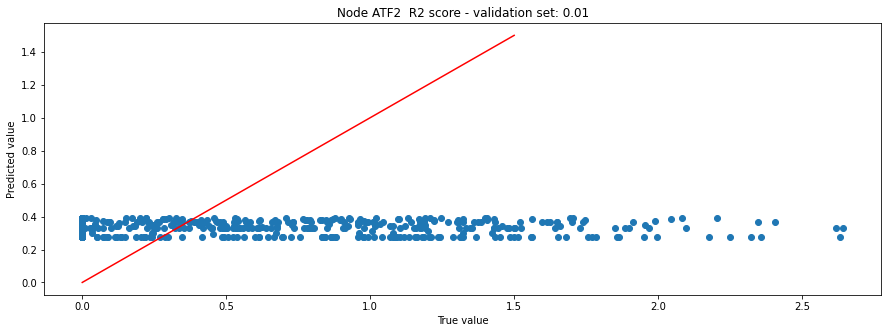

In [28]:
plt.scatter(x = expression_validation_sc[tf], y = ypred_test)
plt.plot( np.linspace(0, 1.5), np.linspace(0,1.5), "r")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.title(f"Node ATF2  R2 score - validation set: {round(sklearn.metrics.r2_score(y_true=expression_validation_sc[tf],y_pred = ypred_test),2)}")
plt.show()

In [37]:
list(G_GRN.predecessors("ATF1"))

['p38']

In [70]:
list(G_GRN.predecessors("p38"))

['MAPK', 'CD3z']

## Fit a random forest to each transcription factor and look up the results

In [60]:


## Fit a random forest to each TF and create a dictionary to save the results
rf_dict = {}
unfit = []
for tf in upstream_nodes_dict:
    print(tf)
    rf = sklearn.ensemble.RandomForestRegressor(random_state=2)

    try:
        rf.fit(X = expression_training_sc[upstream_nodes_dict[tf]],
               y = expression_training_sc[tf])
        rf_dict[tf] = rf
        
    except:
        print(f"{tf} could not be fit")
        unfit.append(tf)

ATF1
ATF2
BCL3
CEBPB
CEBPZ
E2F4
ELK1
ELK4
ESR1
ETS1
FOS
FOSL1
FOSL2
GABPA
GATA1
GATA2
HSF1
IRF3
JUN
JUND
MEF2A
MEF2C
MYC
NANOG
NFAT
NFATC1
REST
RXRA
SP1
STAT1
STAT3
STAT5
TAL1
Bcl2
BclXL
GADS
IFNG
IL2
IL6
TNFa
cmyc
mTOR


In [61]:
## For each model that was fit: predict and assess fit on the training and validation set

score_dict = {}
prediction_dict = {}
for tf in rf_dict:
    parents = upstream_nodes_dict[tf]
    ypred_test = rf_dict[tf].predict(expression_validation_sc[parents])
    ypred_train = rf_dict[tf].predict(expression_training_sc[parents])

    prediction_dict[tf] = (ypred_train, ypred_test)
    
    score_train = sklearn.metrics.r2_score(y_true=expression_training_sc[tf],
                                         y_pred = ypred_train)
    score_test = sklearn.metrics.r2_score(y_true=expression_validation_sc[tf],
                                         y_pred = ypred_test)
    score_dict[tf] = (score_train, score_test)
    print(f"{tf}:  {score_dict[tf]} ")

ATF1:  (0.8182190850628692, -0.20639406078707268) 
ATF2:  (0.5102305667371967, -0.3029775725937913) 
BCL3:  (0.8433914150156652, -0.11399234596368091) 
CEBPB:  (0.5132711317406788, -0.27482067952488) 
CEBPZ:  (0.7906419537732403, -0.18731252811818444) 
E2F4:  (0.8434167089245663, -0.06755557650415422) 
ELK1:  (0.5337147270387077, -0.32262037964585266) 
ELK4:  (0.8362321588137014, -0.13657194415345608) 
ESR1:  (0.8365896669302263, -0.16364091437961048) 
ETS1:  (0.8283101774271173, -0.08984335640481089) 
FOS:  (0.8515433466921156, -0.06641956709655883) 
FOSL1:  (0.7865100446230683, -0.22941872962877308) 
FOSL2:  (0.8424501063792125, -0.1002281678544028) 
GABPA:  (0.8401802027107862, -0.07542833222154166) 
GATA1:  (1.0, 1.0) 
GATA2:  (0.8537163870757737, -0.21397491363067855) 
HSF1:  (0.843373530346923, -0.10167832323569748) 
IRF3:  (0.8259147093340564, -0.10619511062488063) 
JUN:  (0.8310191004619787, -0.10810457219217917) 
JUND:  (0.7813056478899431, -0.262927475304952) 
MEF2A:  (0.8000

/tmp/ipykernel_393361/1747638262.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


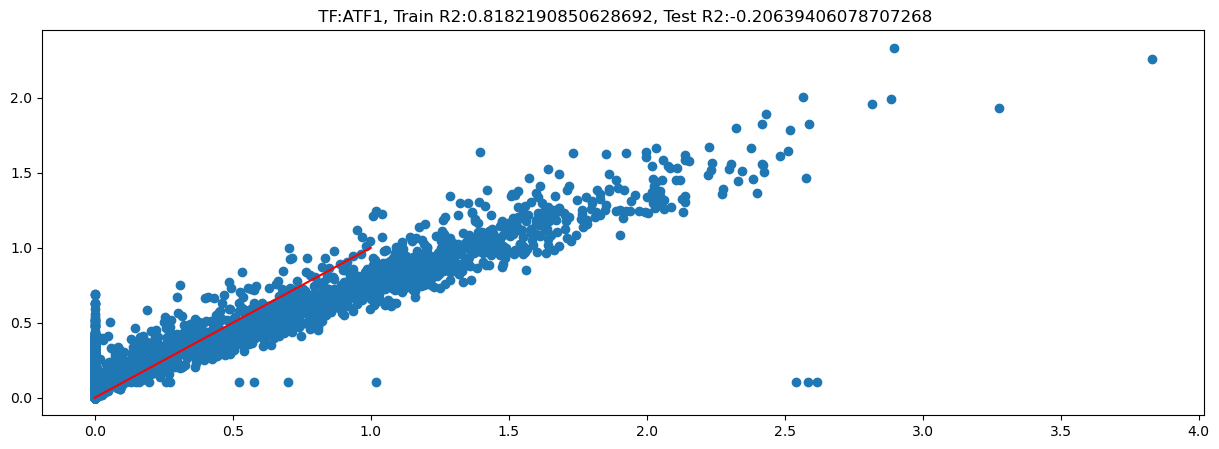

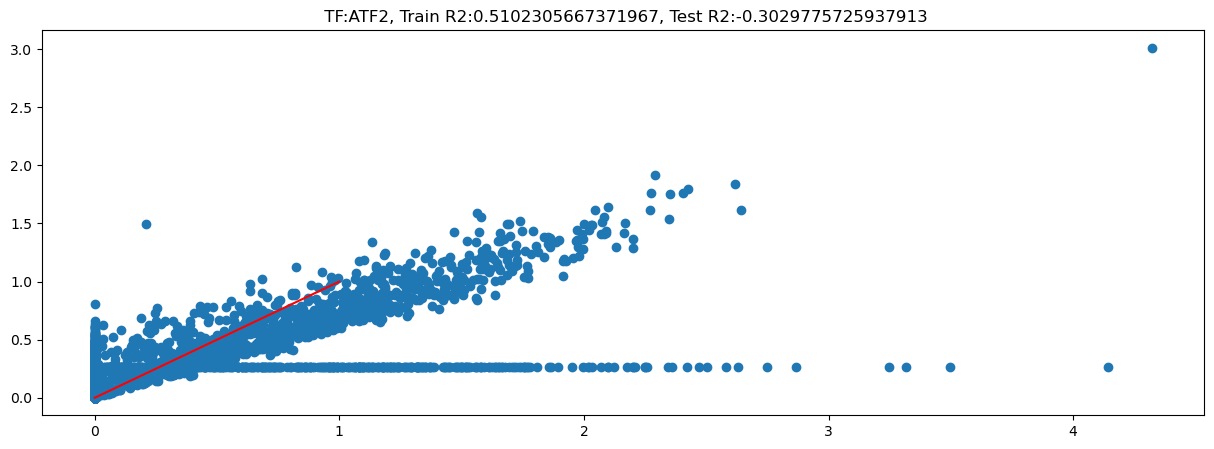

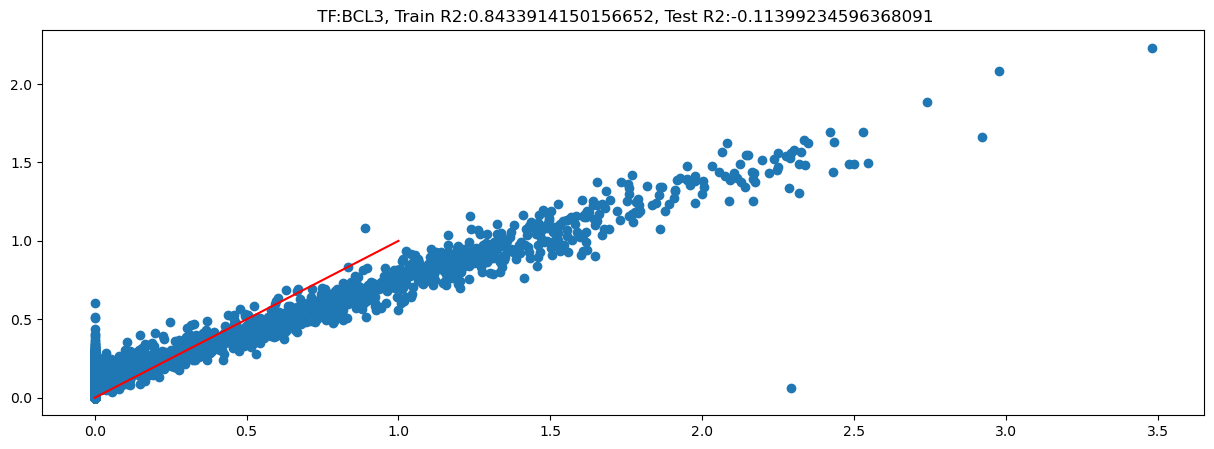

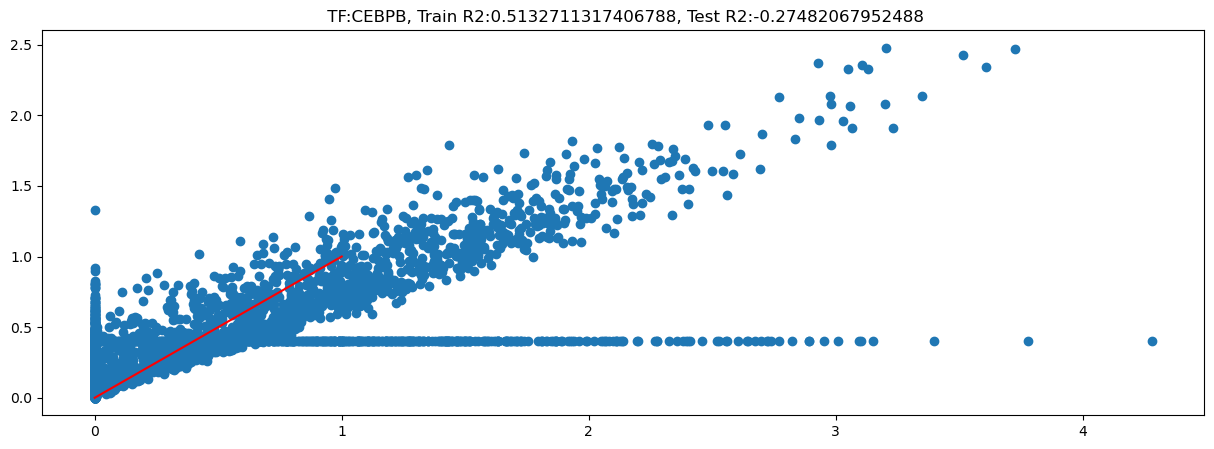

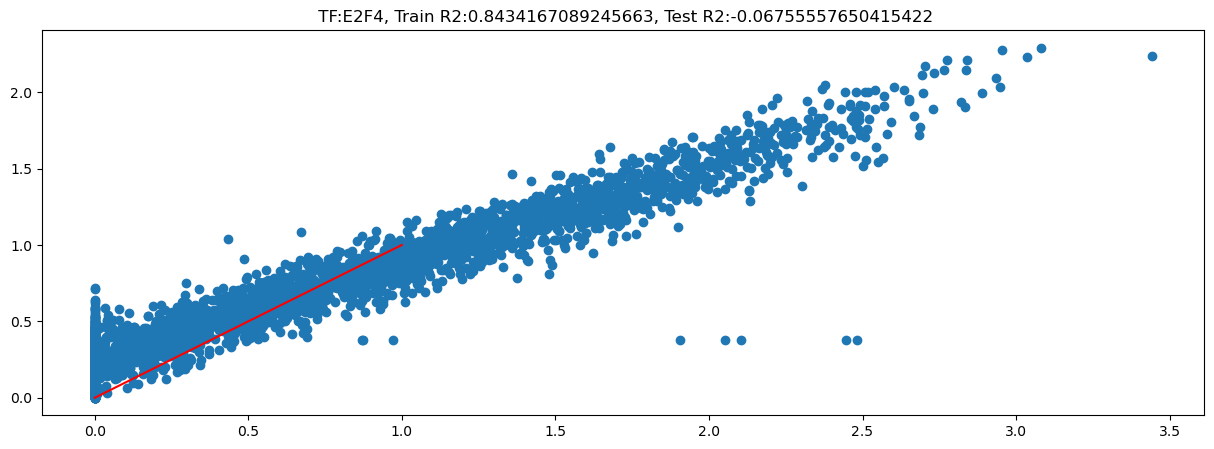

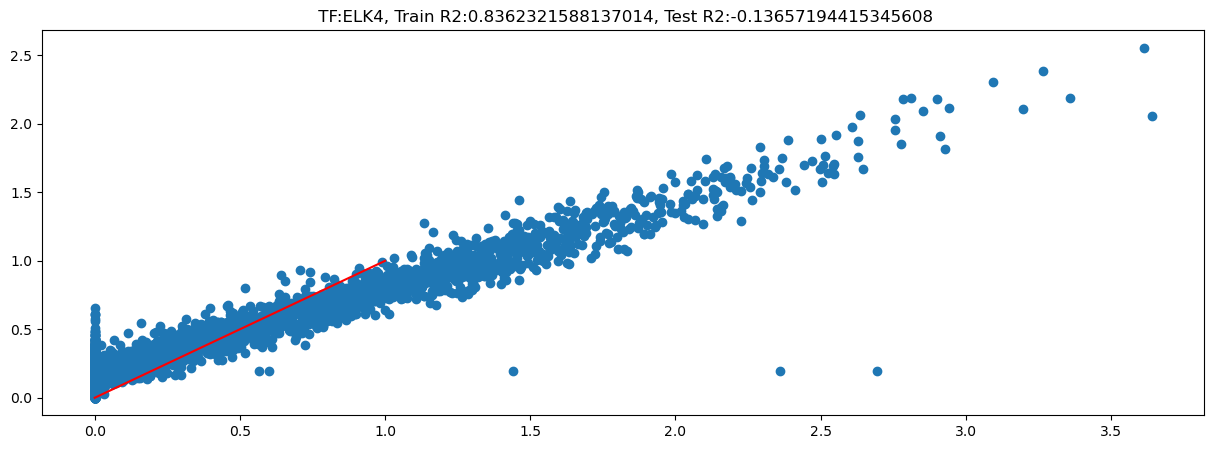

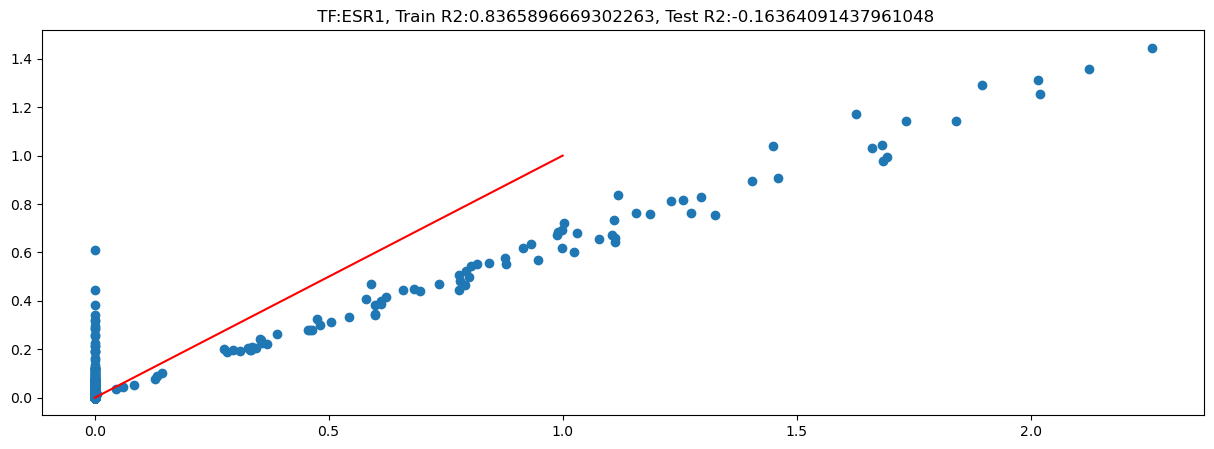

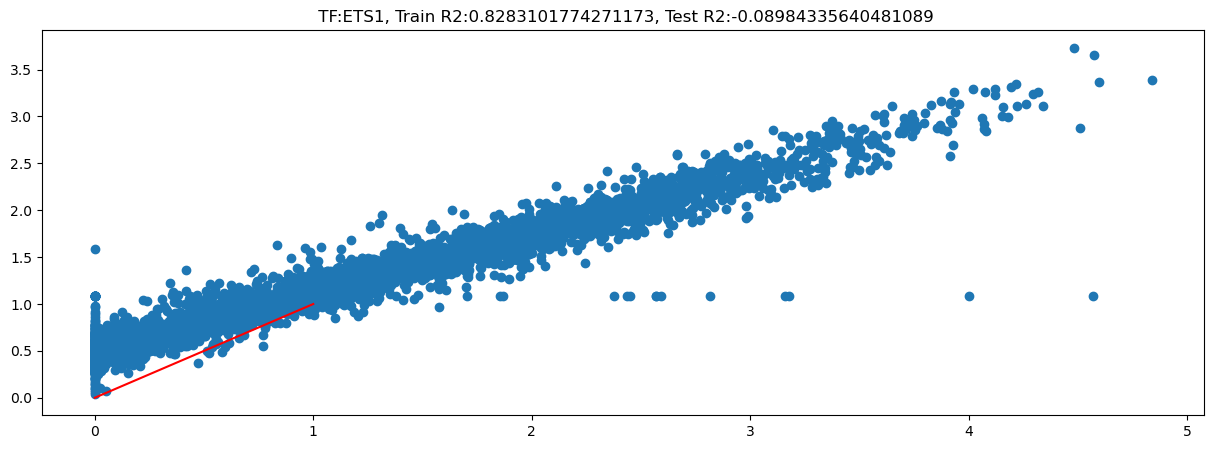

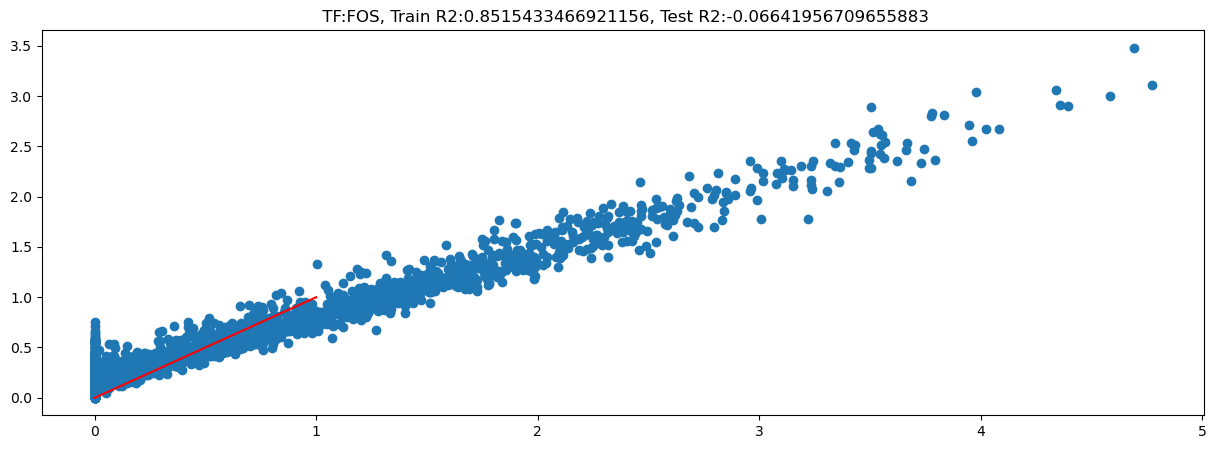

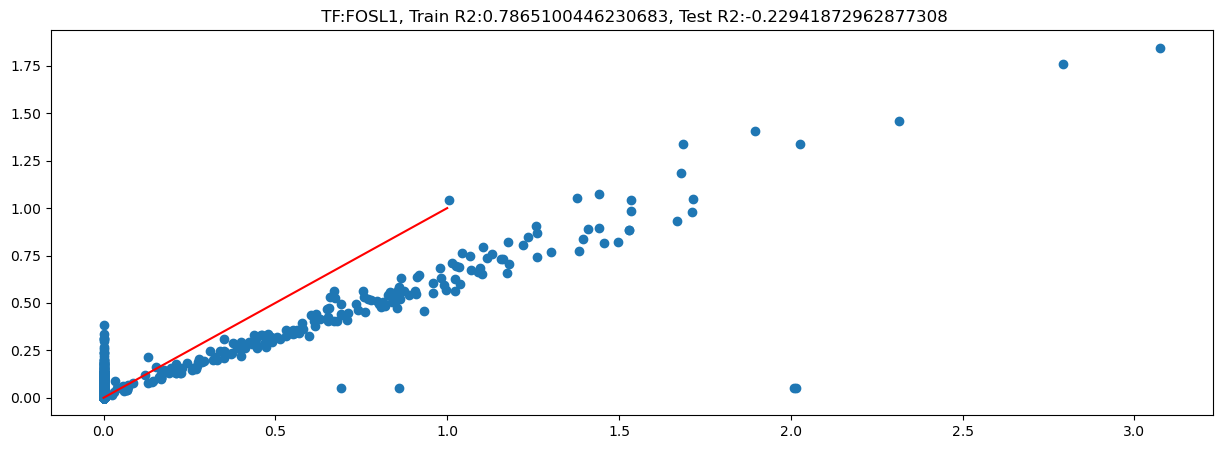

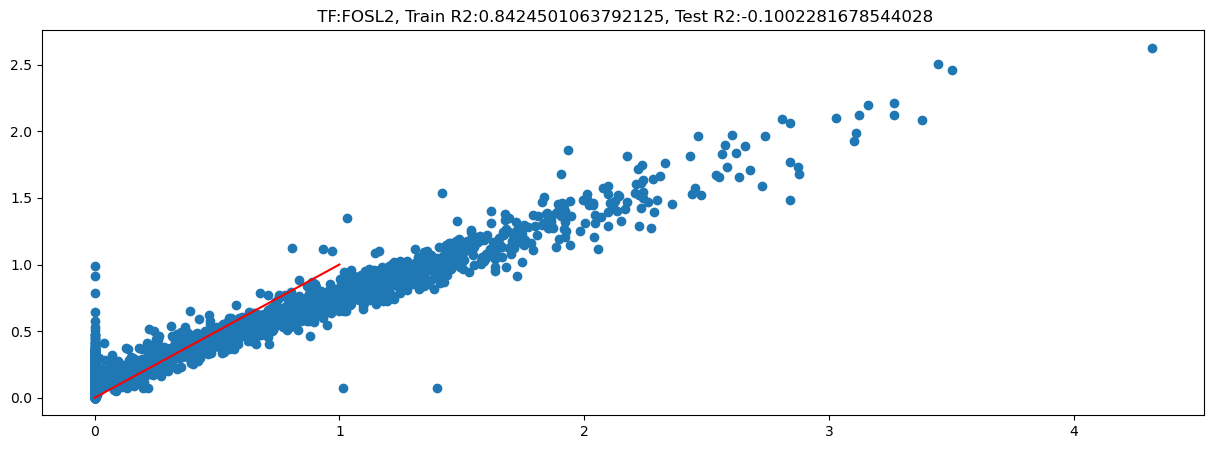

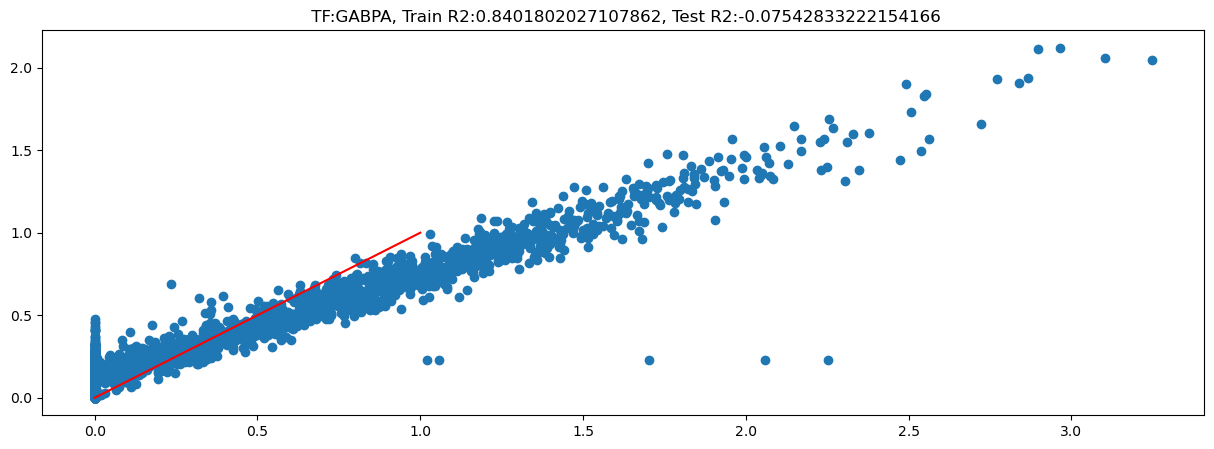

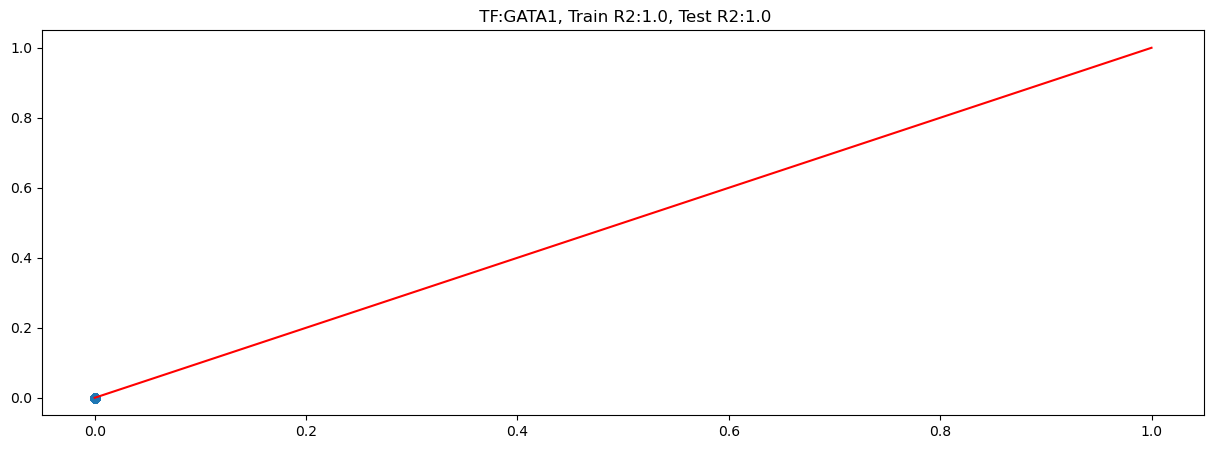

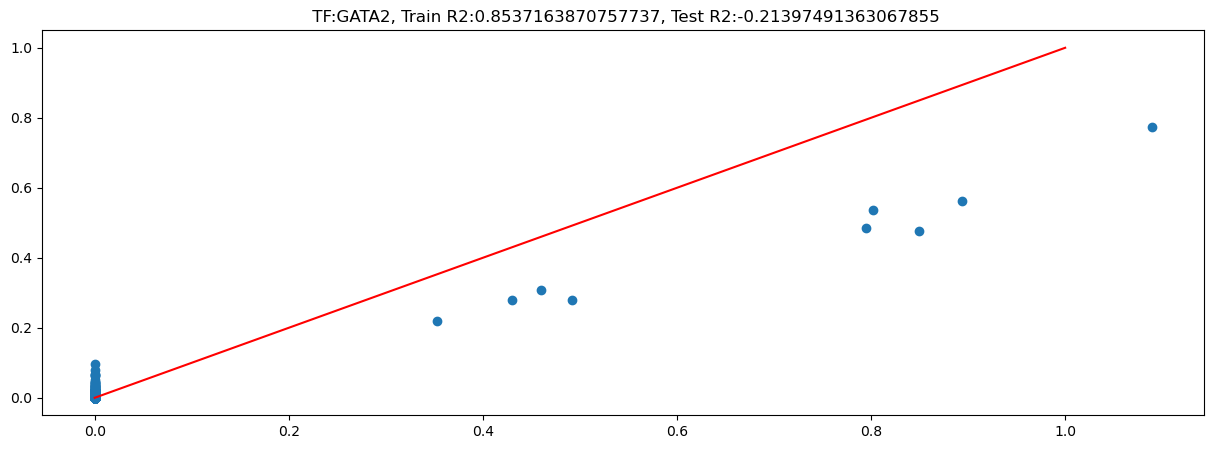

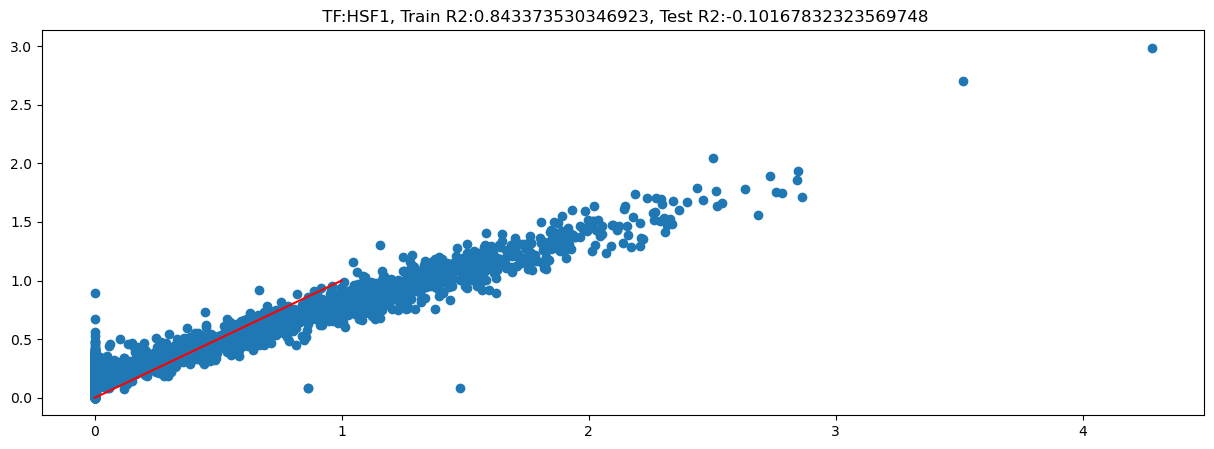

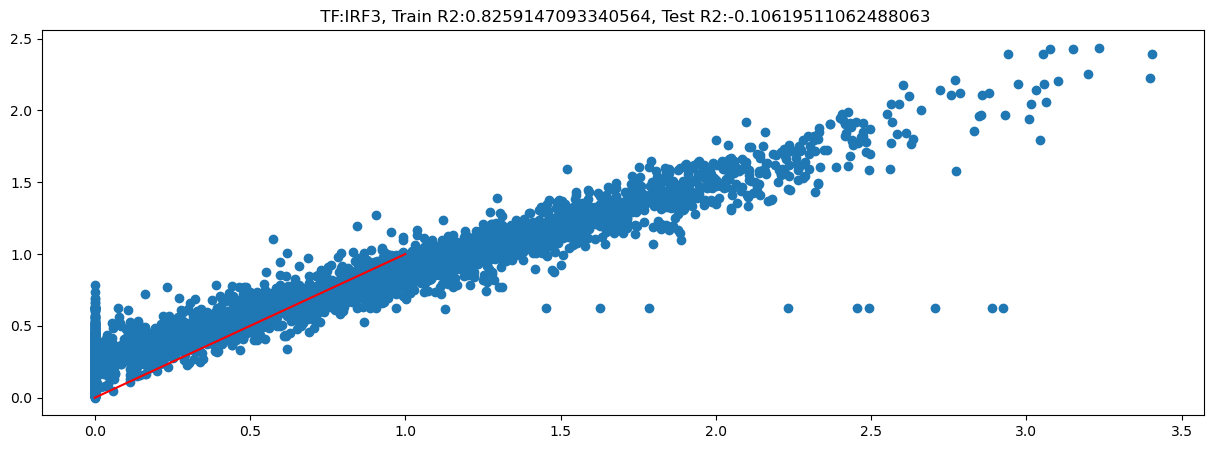

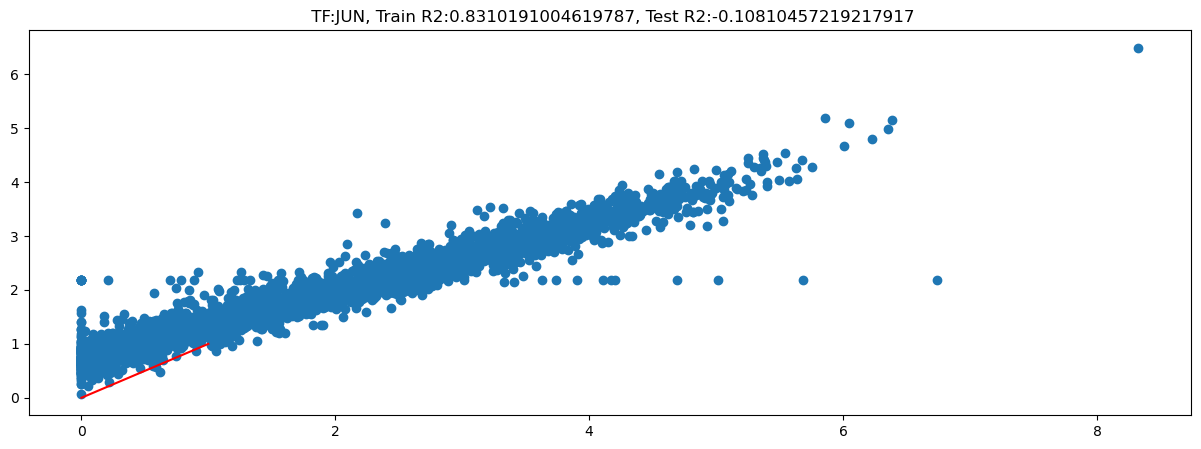

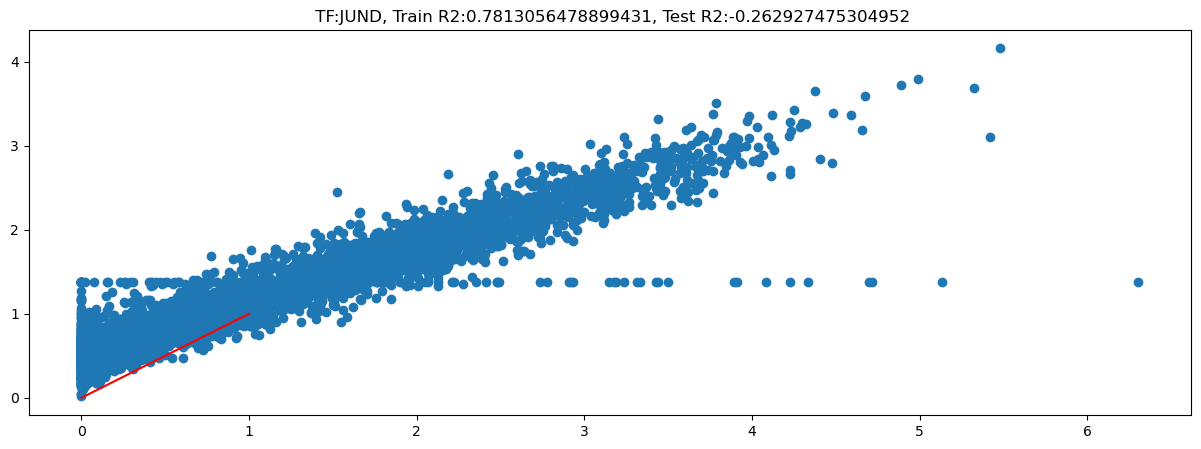

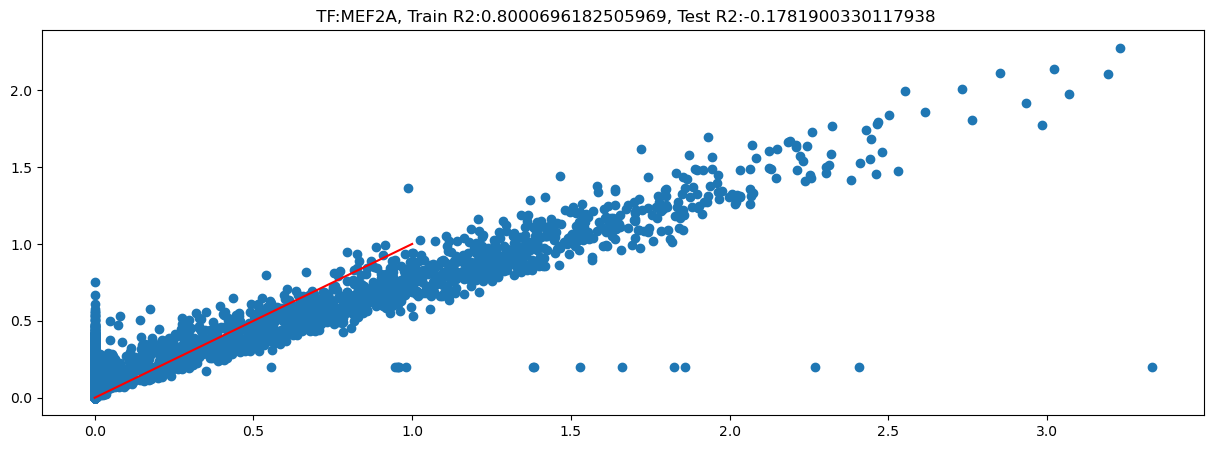

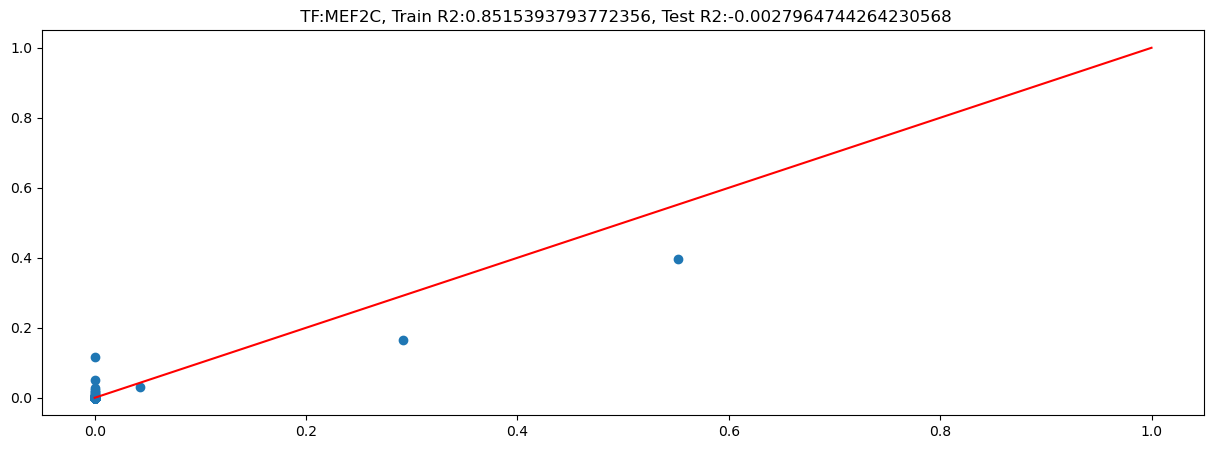

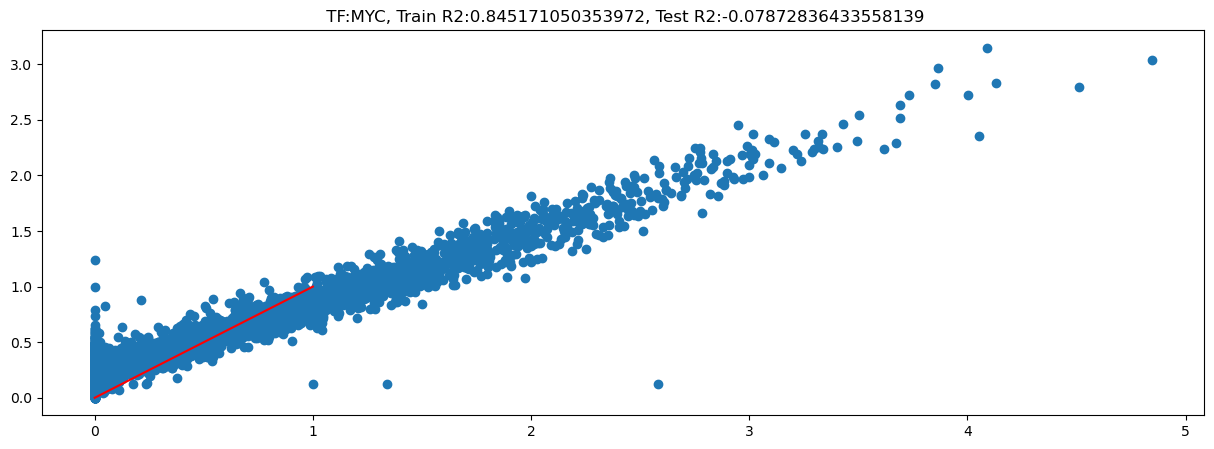

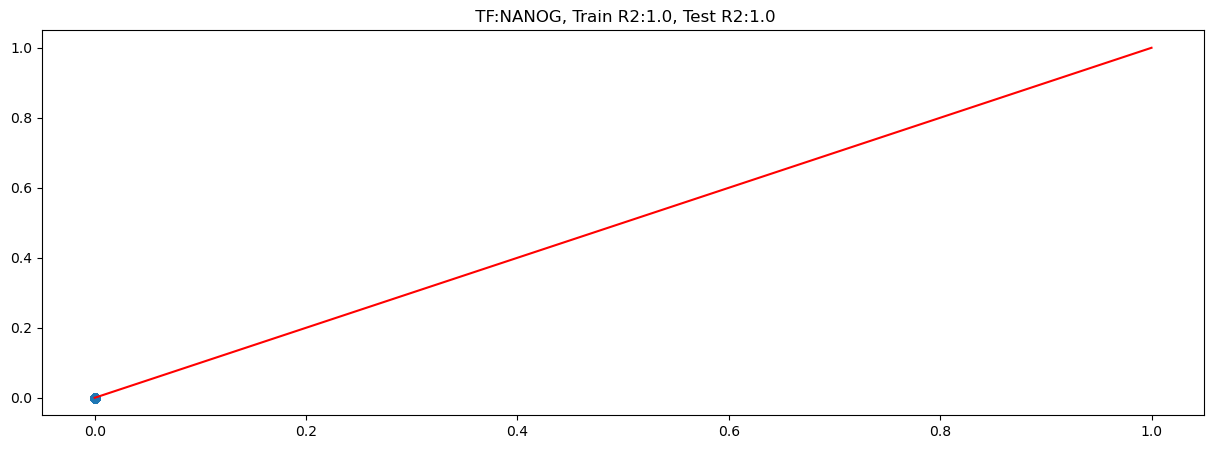

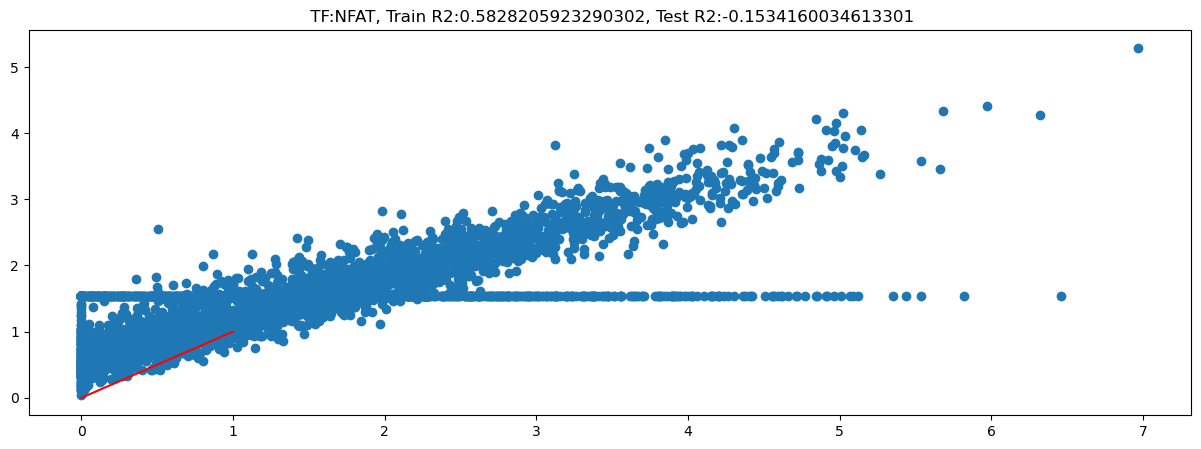

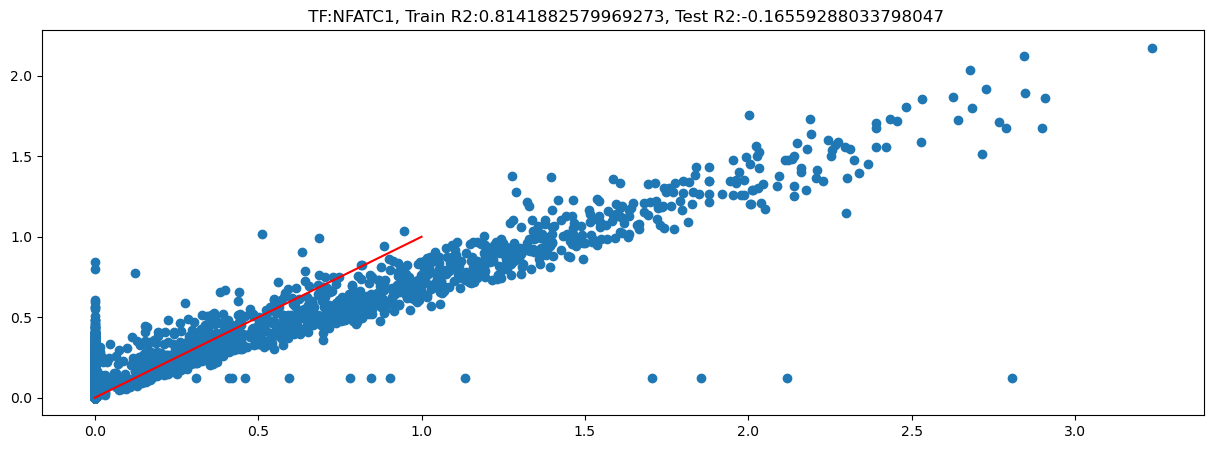

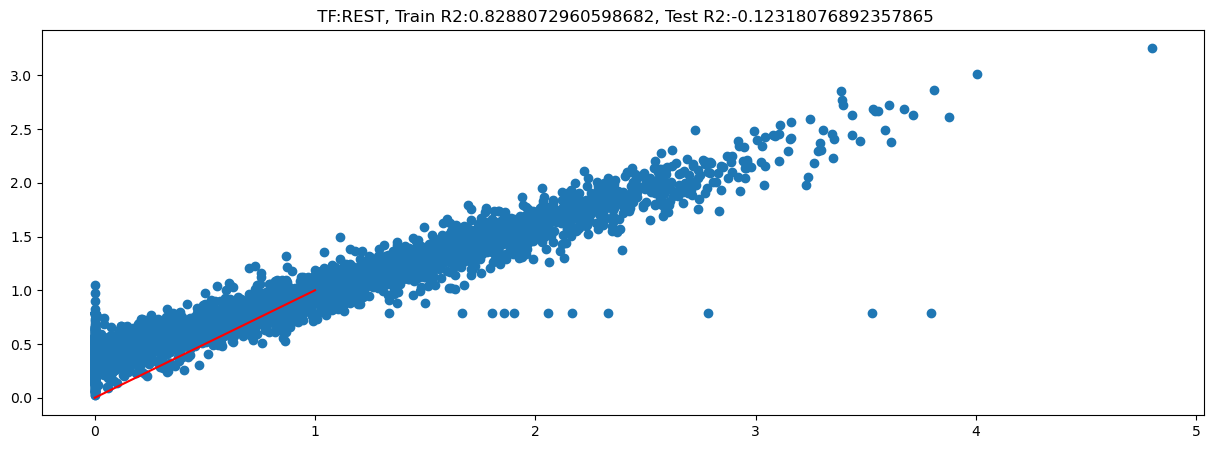

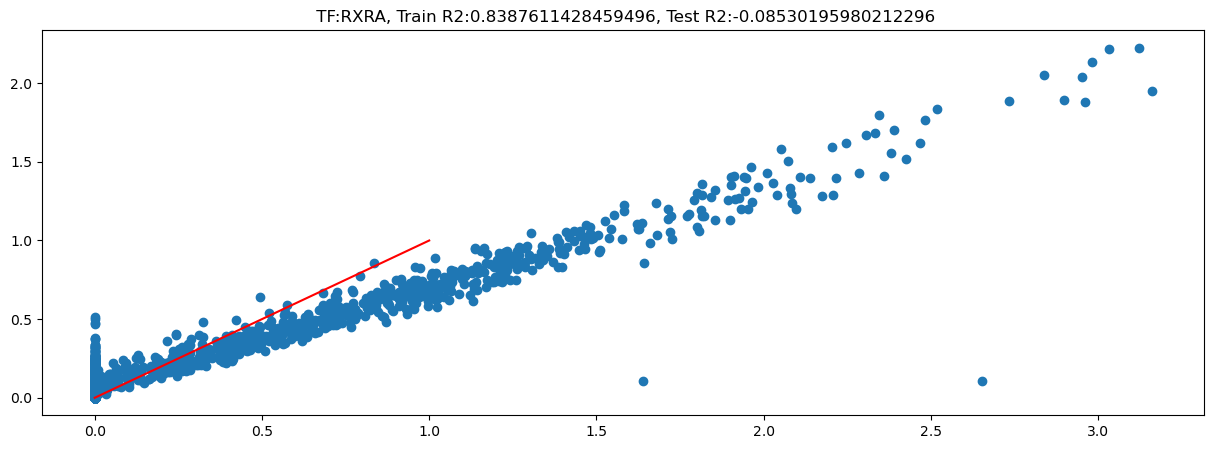

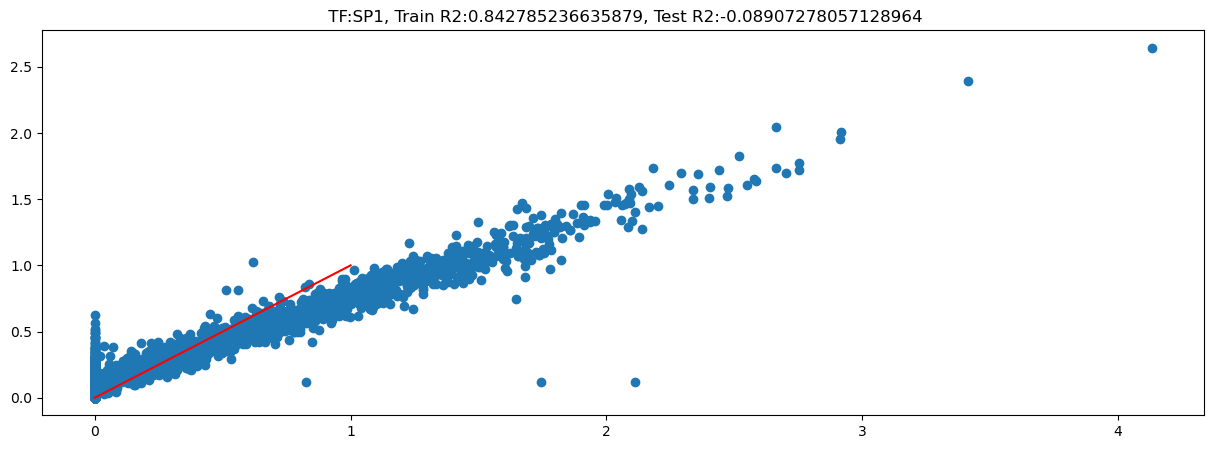

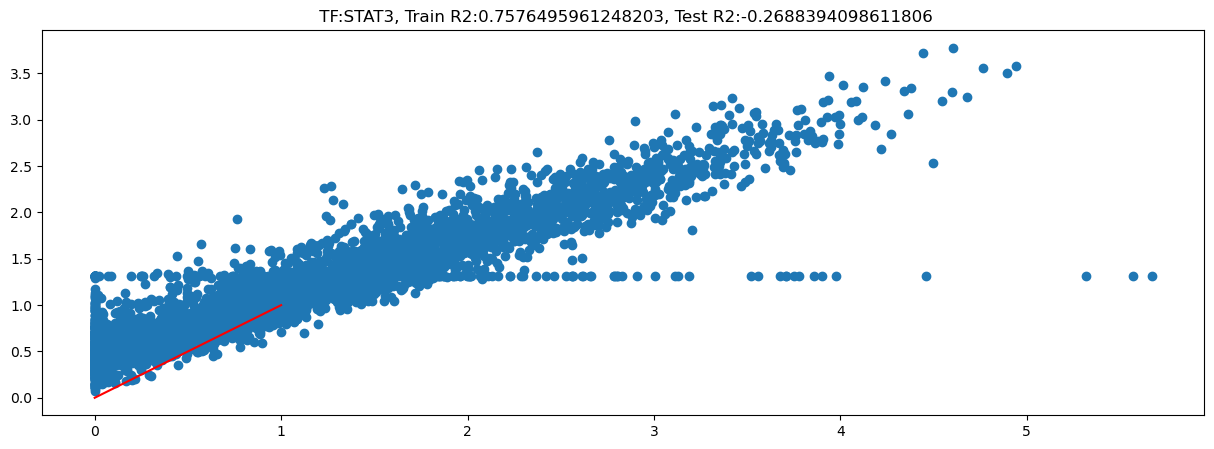

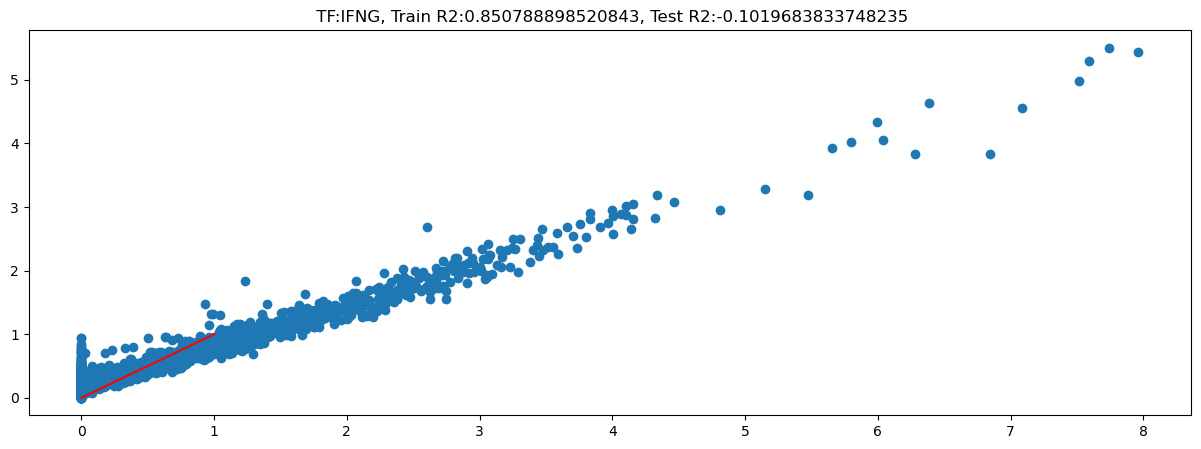

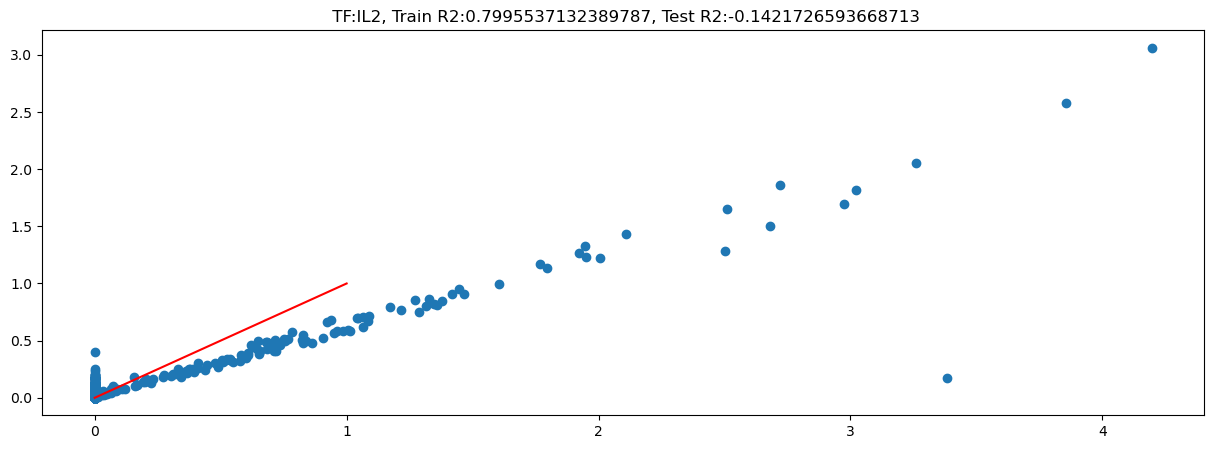

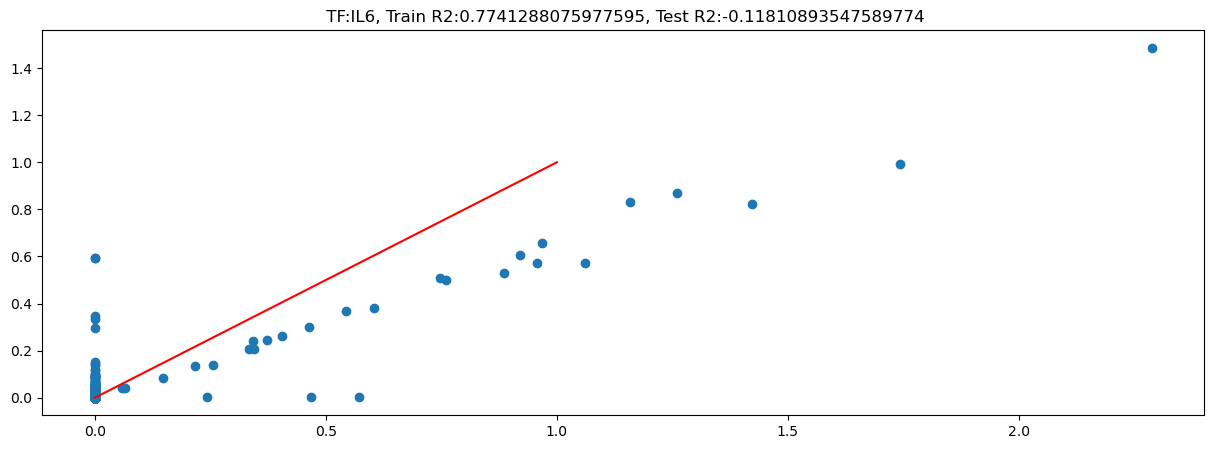

In [62]:
## Examine all the relationships by plotting true value vs predicted value

for tf in prediction_dict:
    plt.figure()
    plt.scatter(x = expression_training_sc[tf], y = prediction_dict[tf][0])
    X = np.linspace(0,1)
    plt.plot( X, X, "r")
    plt.title( f" TF:{tf}, Train R2:{score_dict[tf][0]}, Test R2:{score_dict[tf][1]}")


In [63]:
plt.close('all')

/tmp/ipykernel_393361/1020139048.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


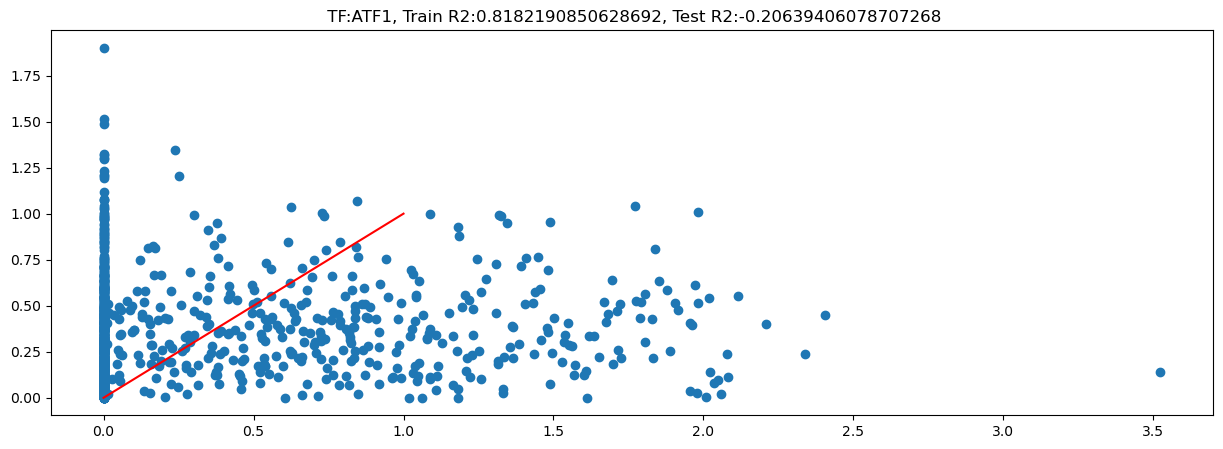

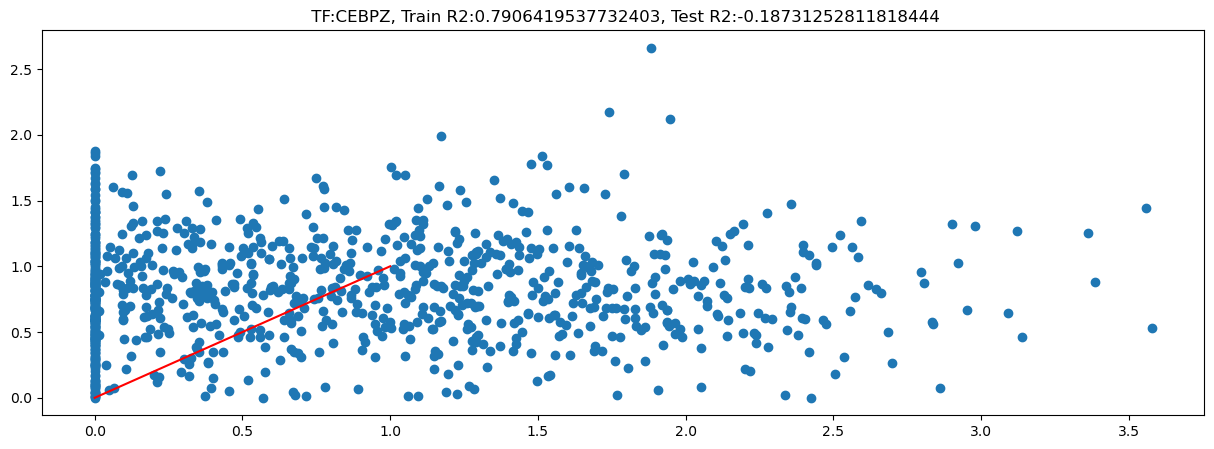

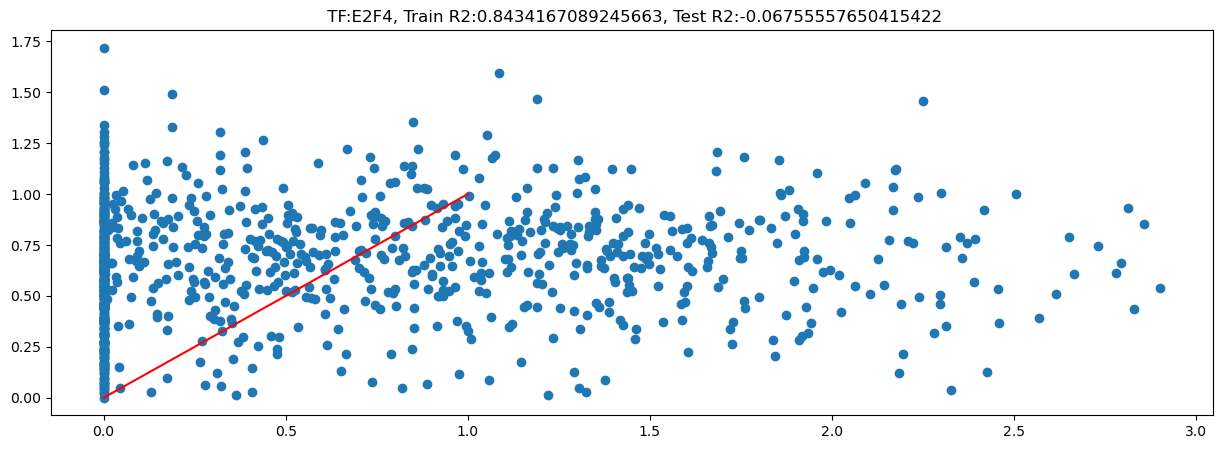

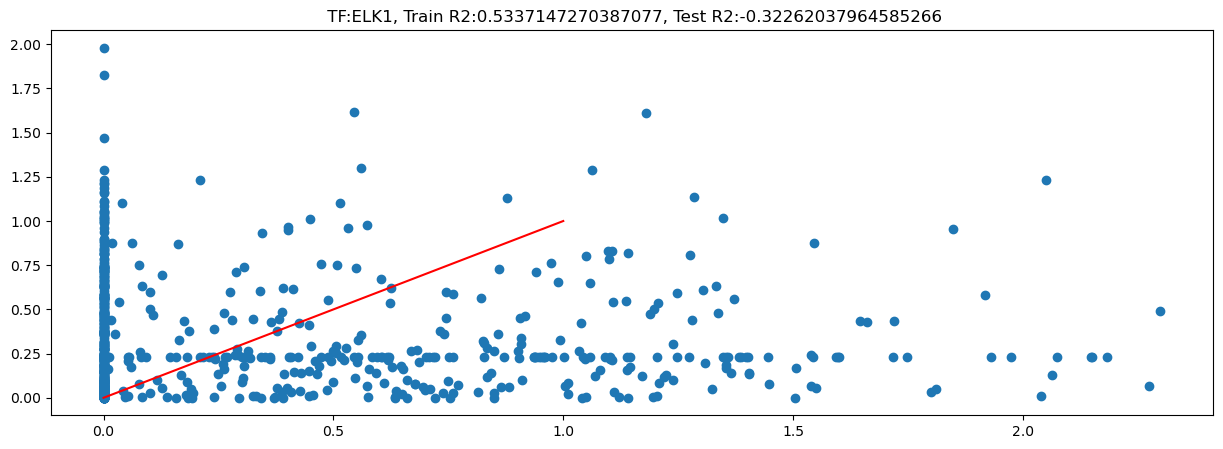

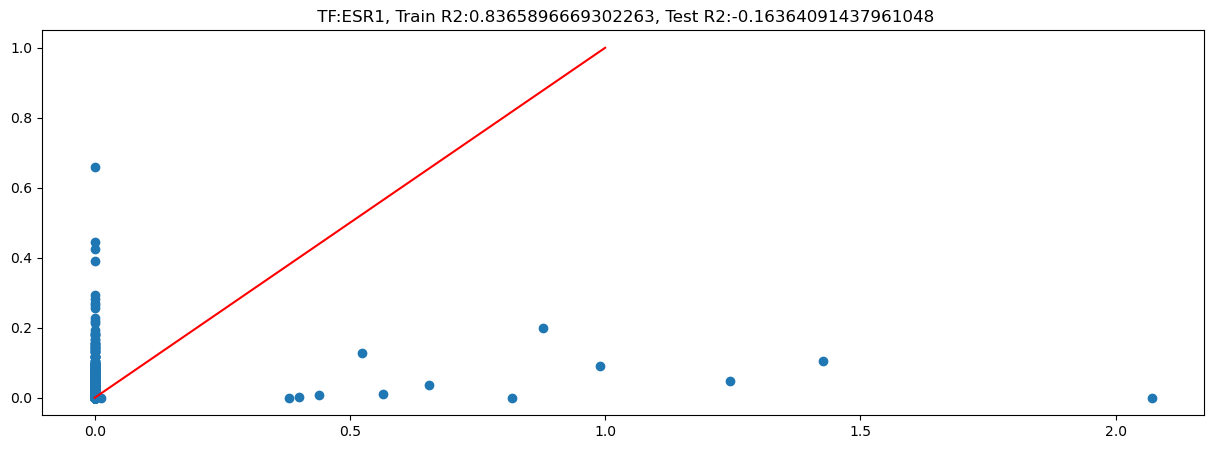

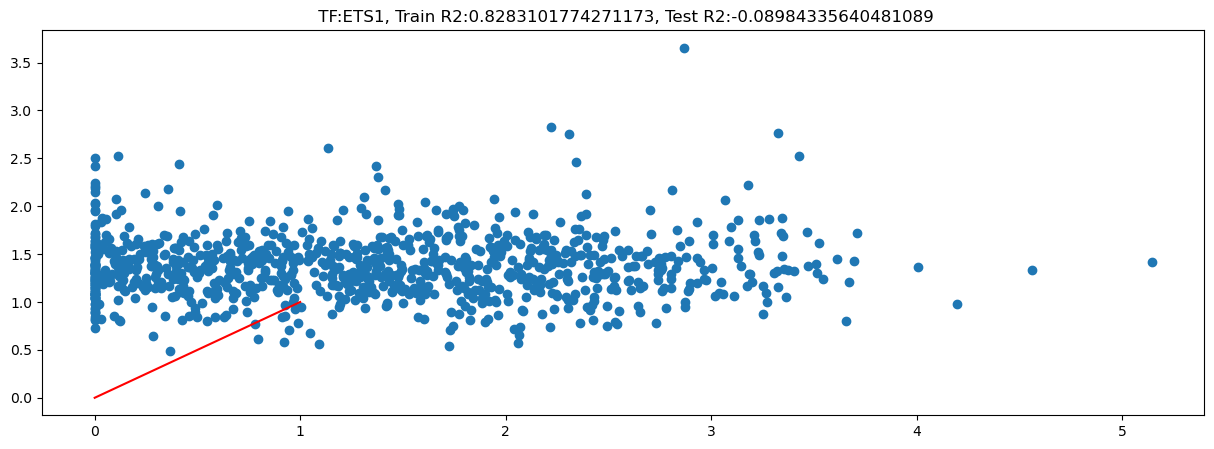

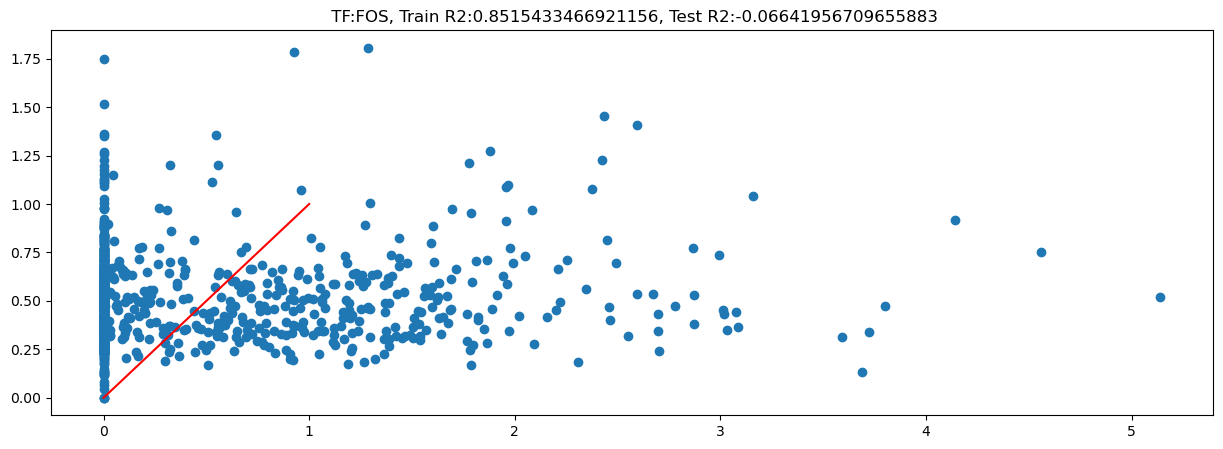

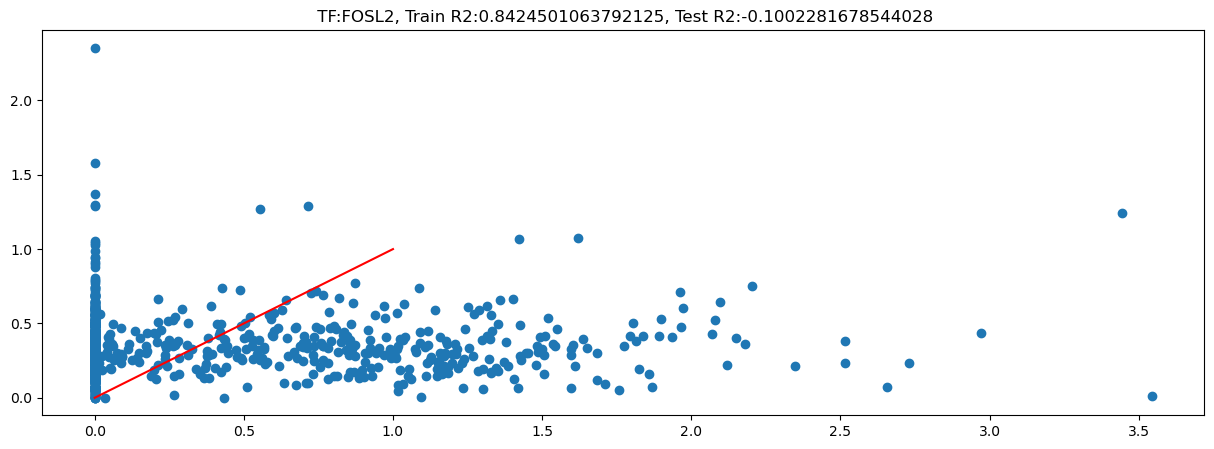

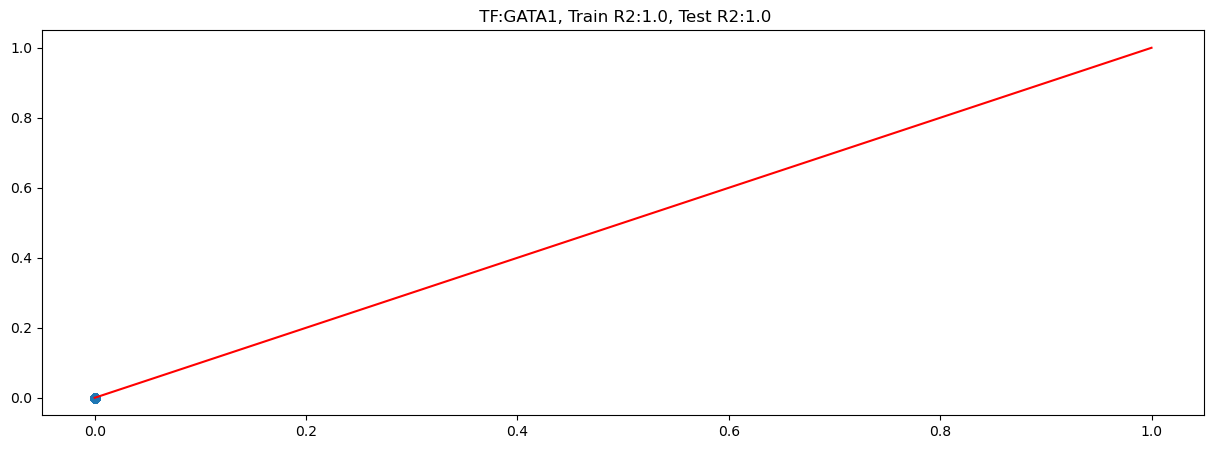

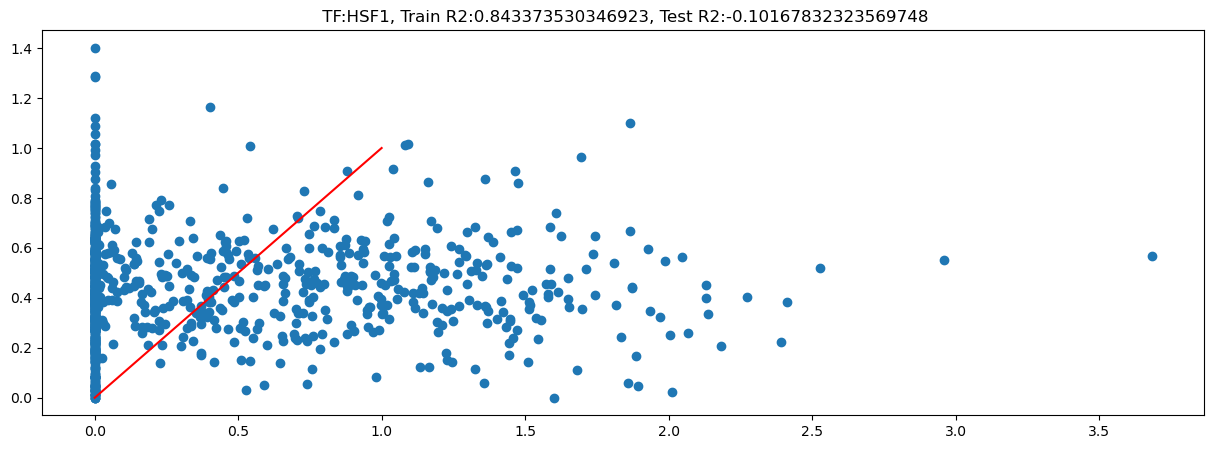

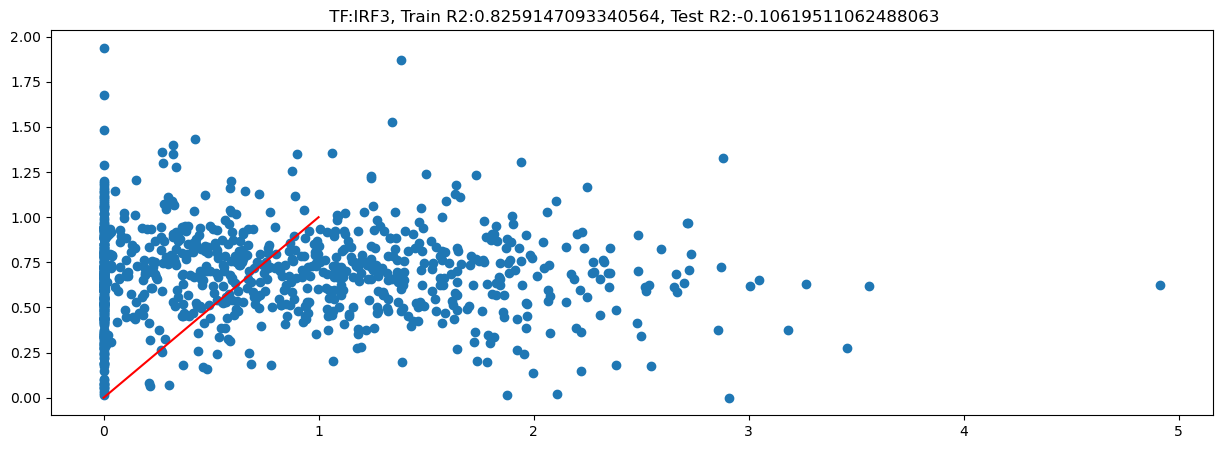

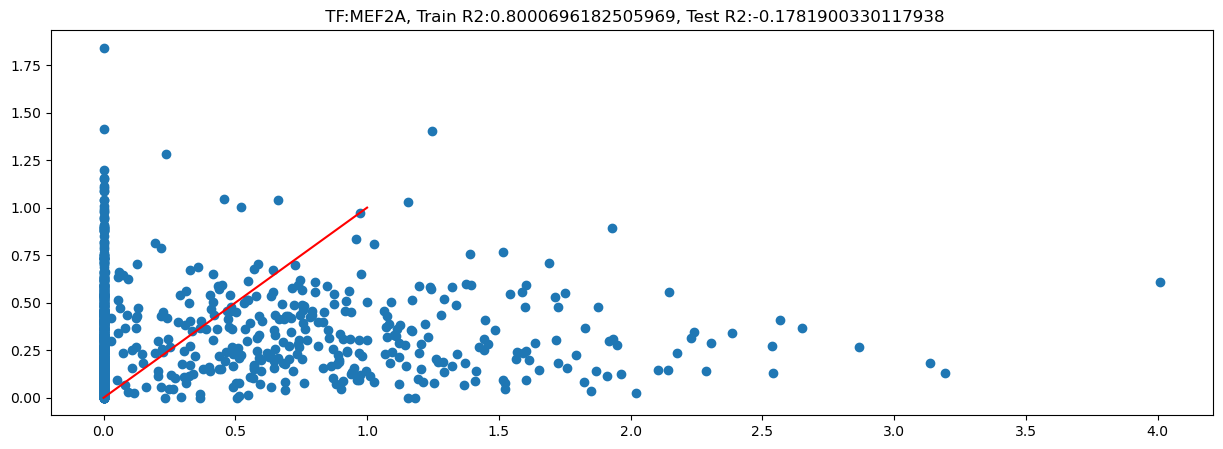

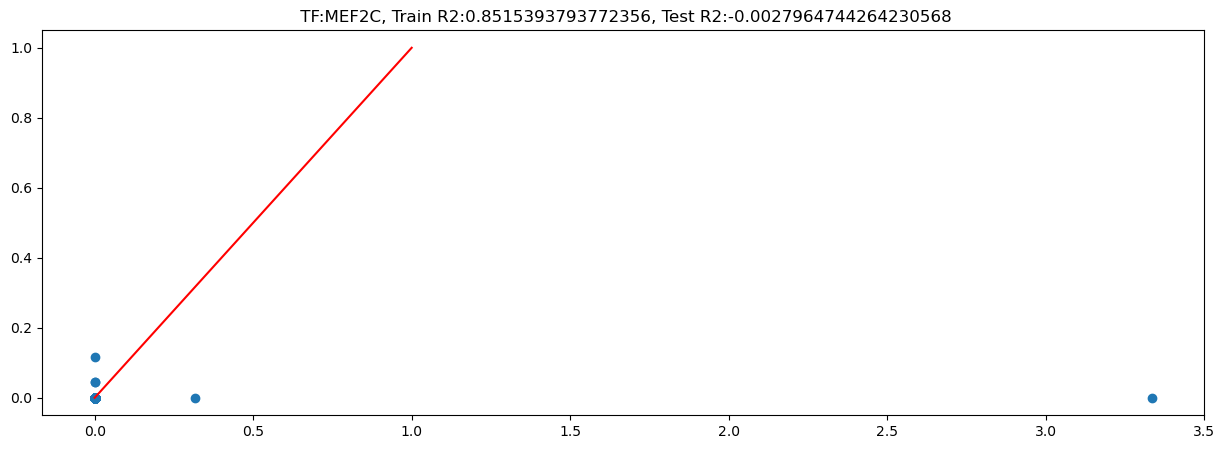

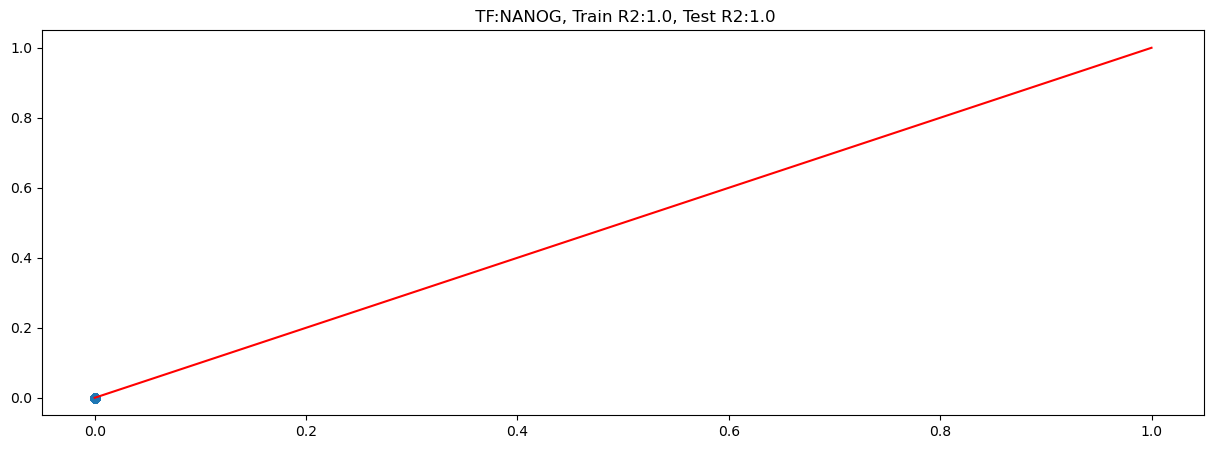

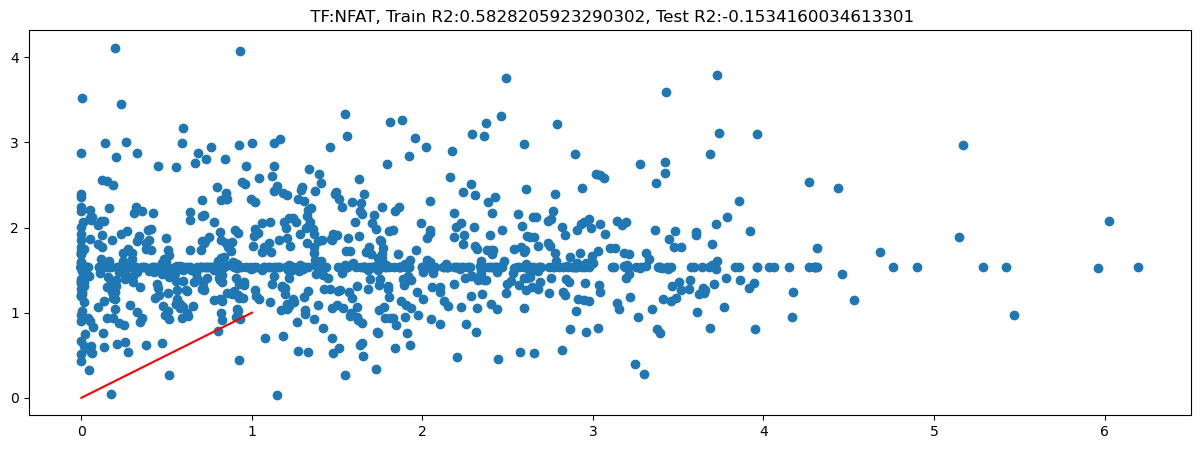

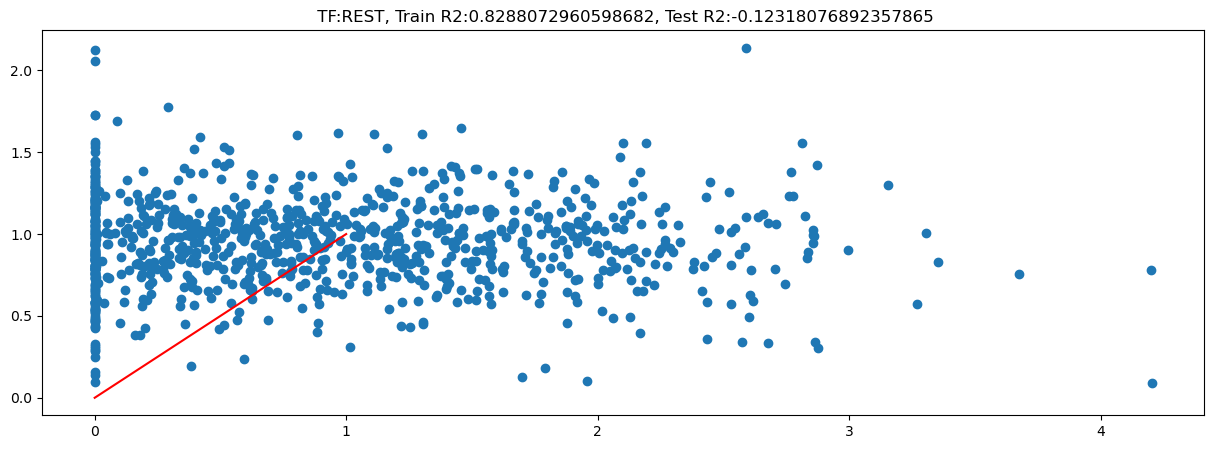

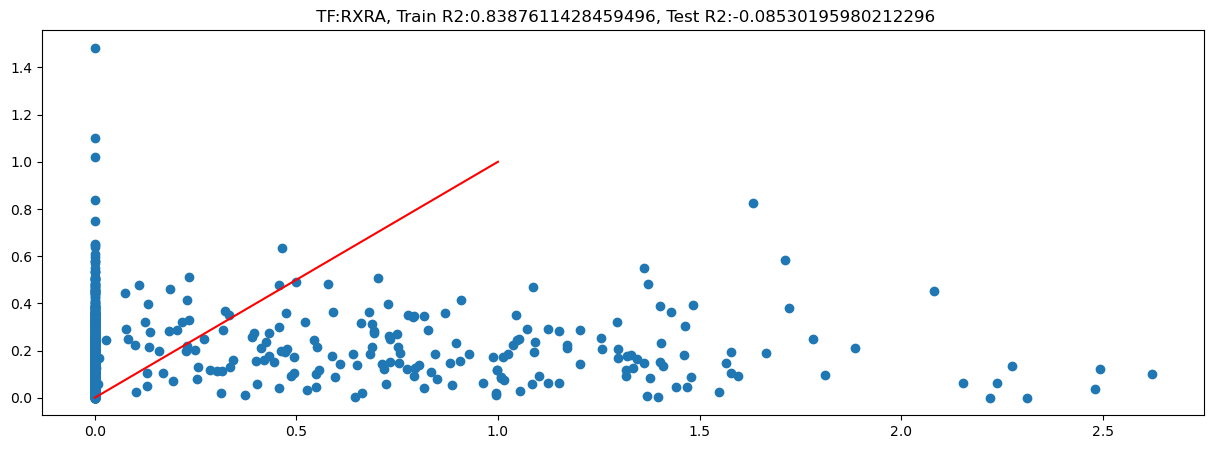

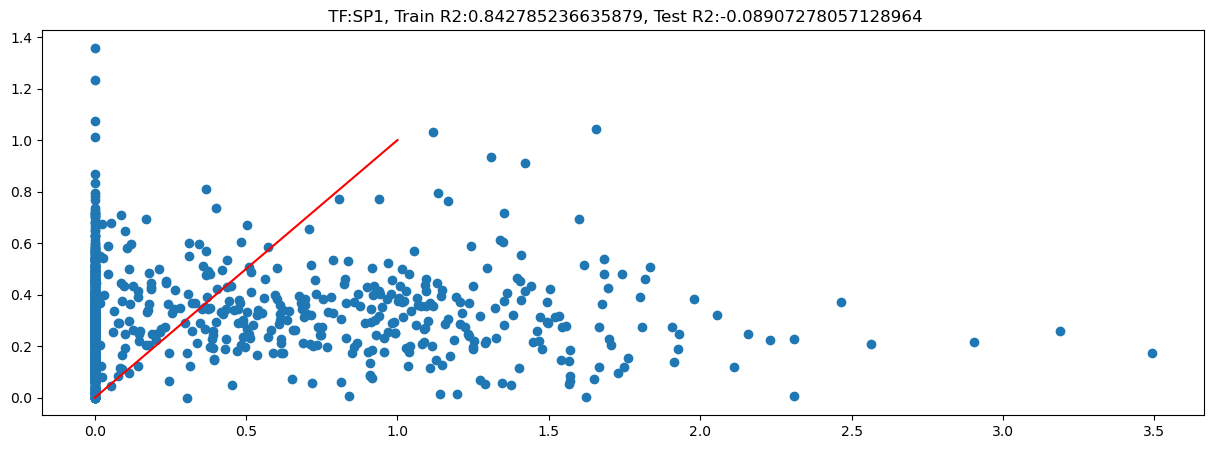

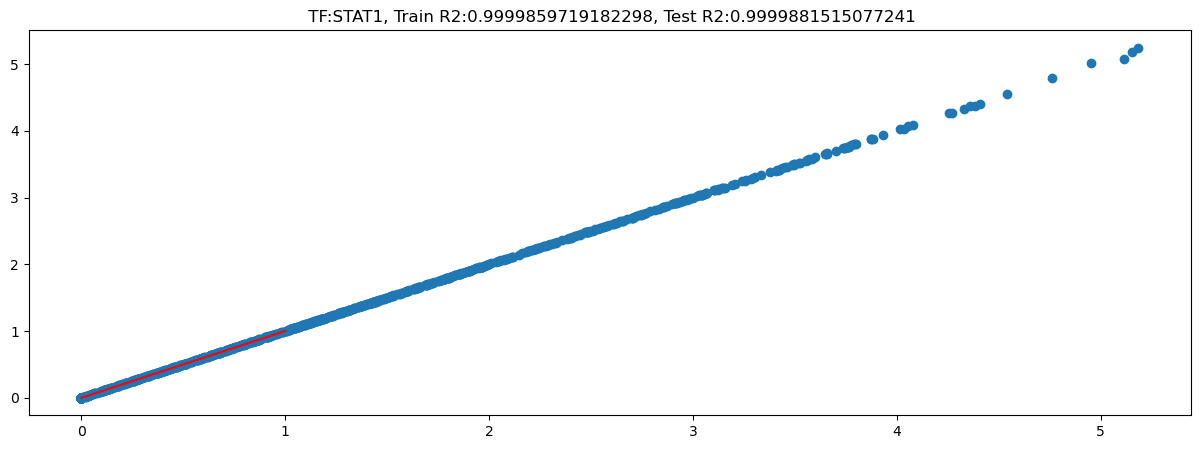

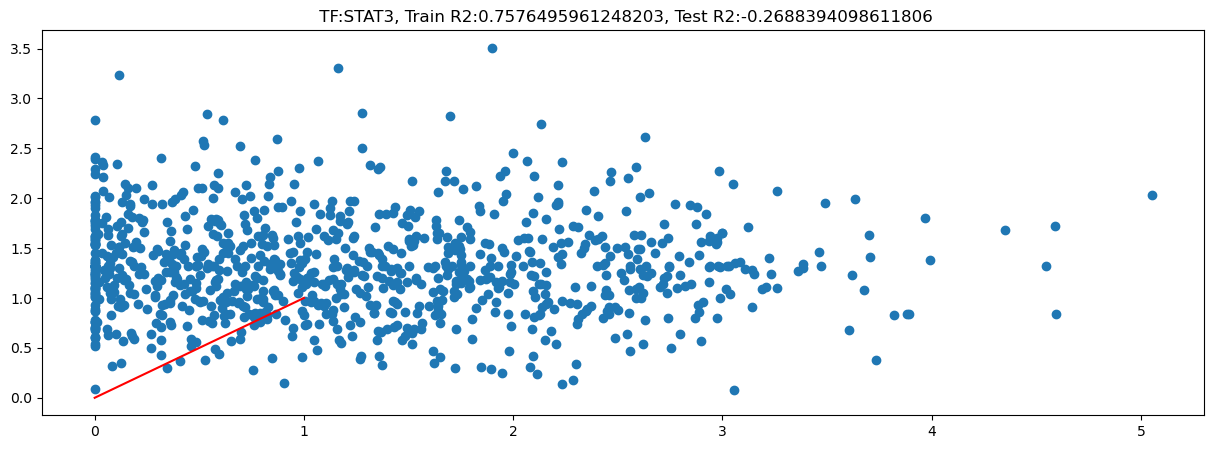

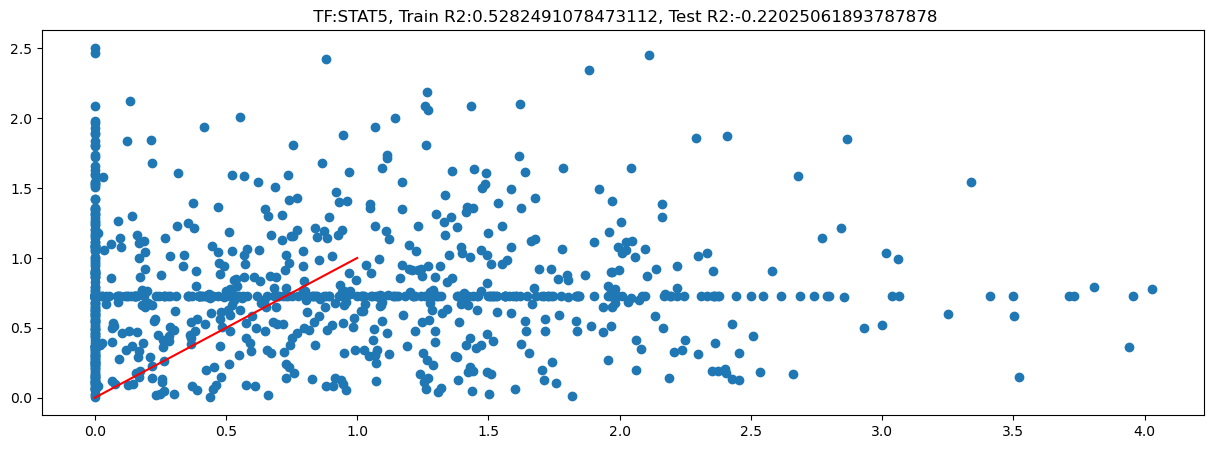

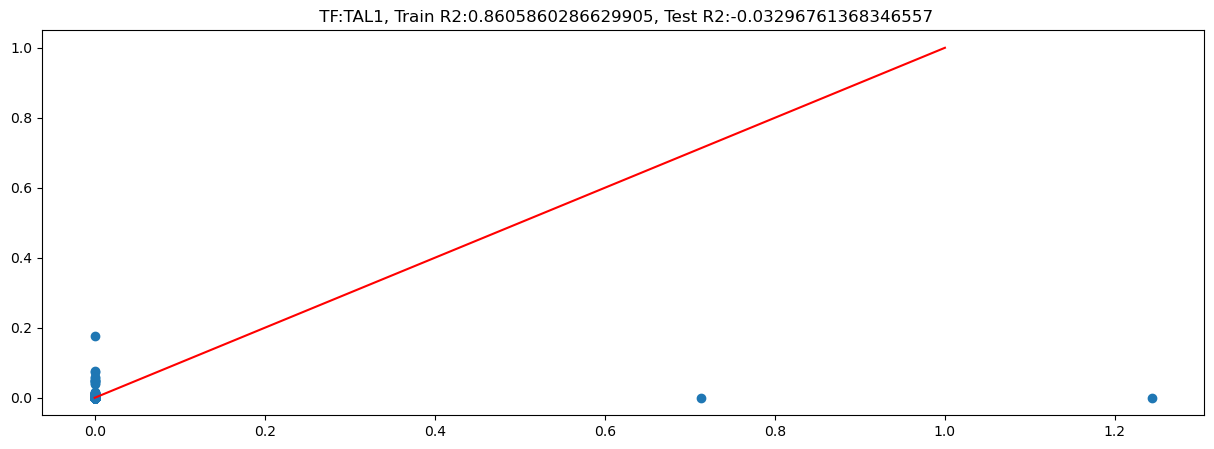

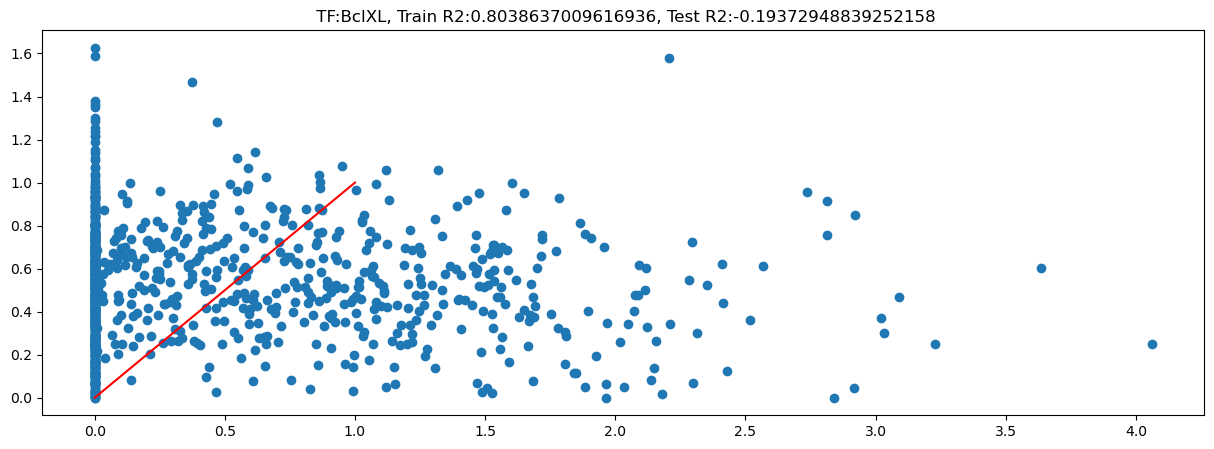

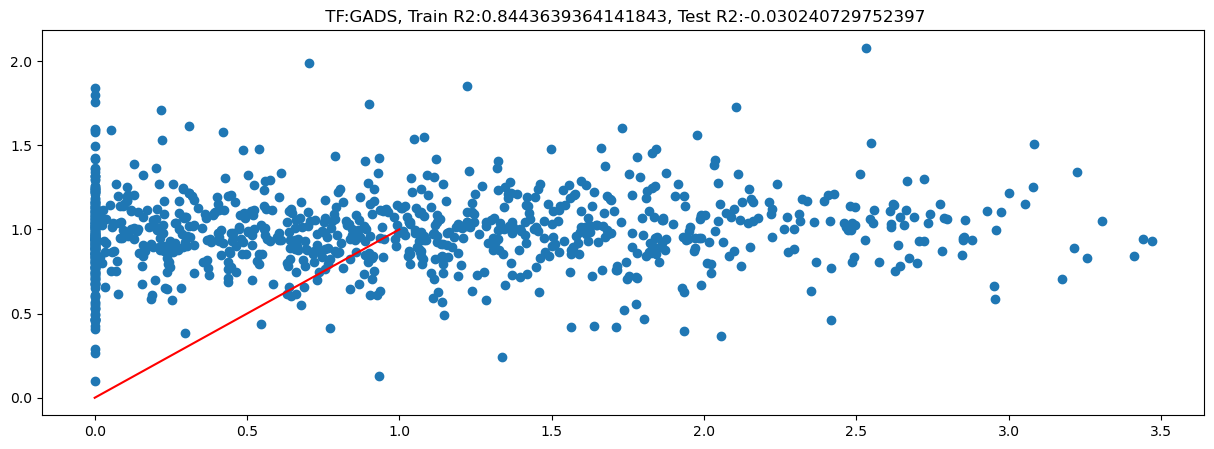

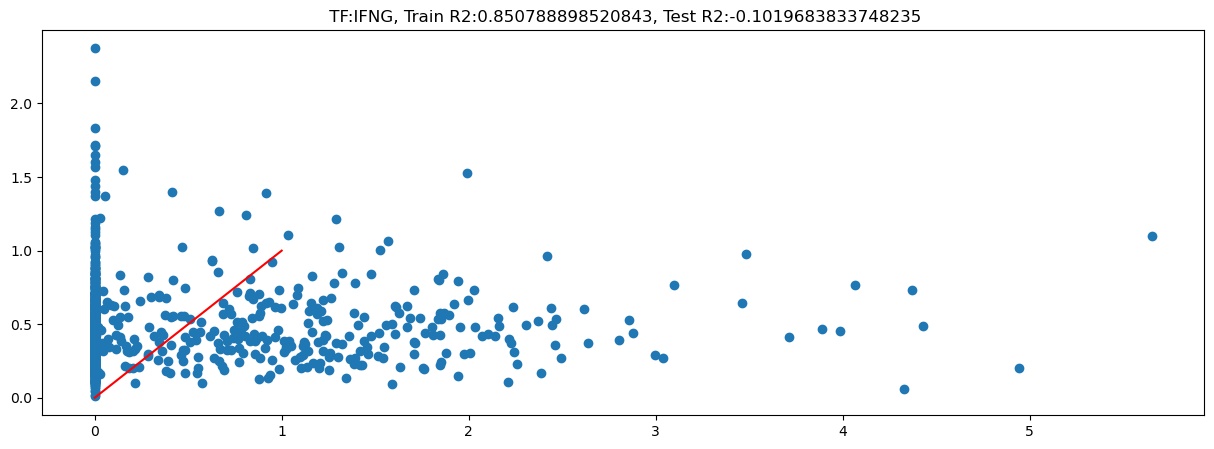

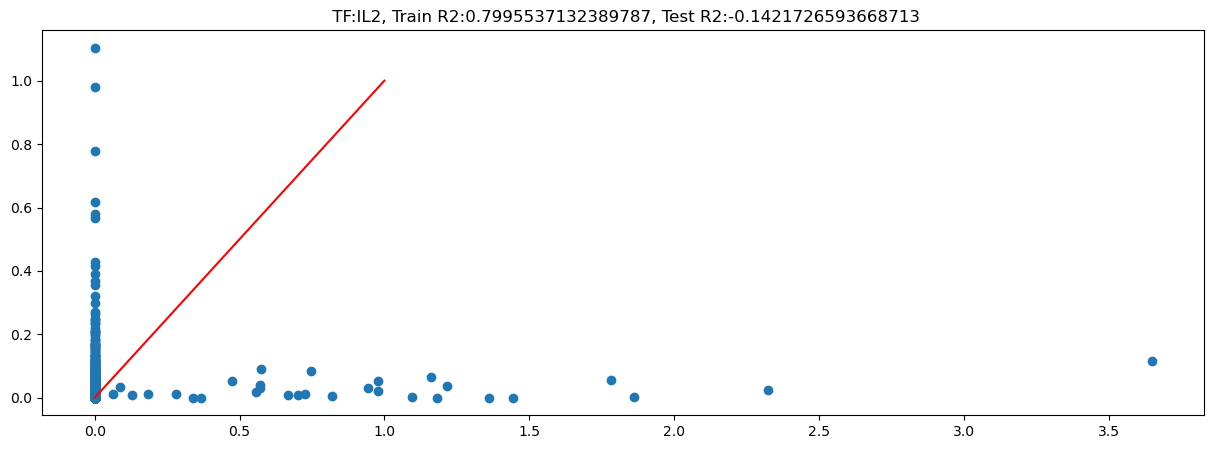

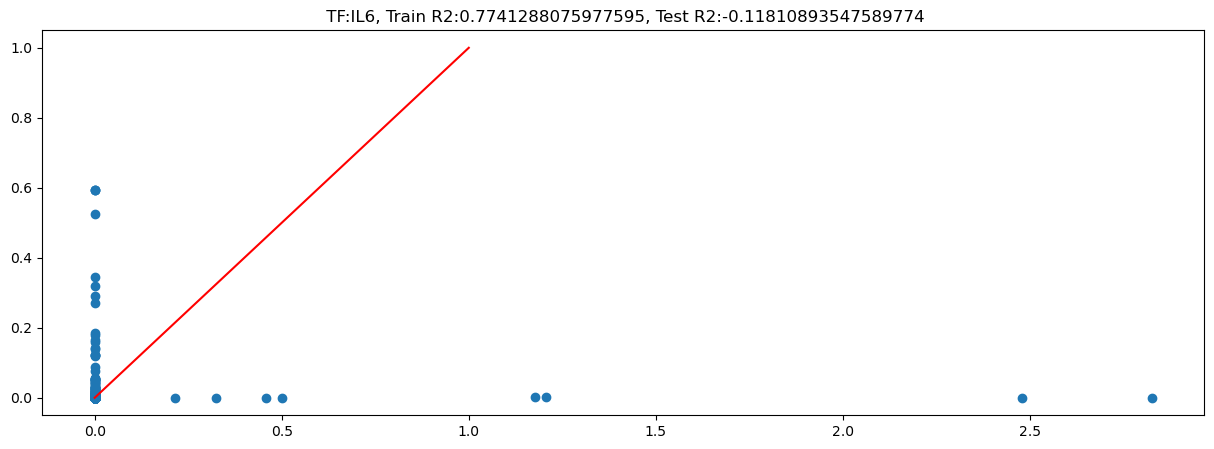

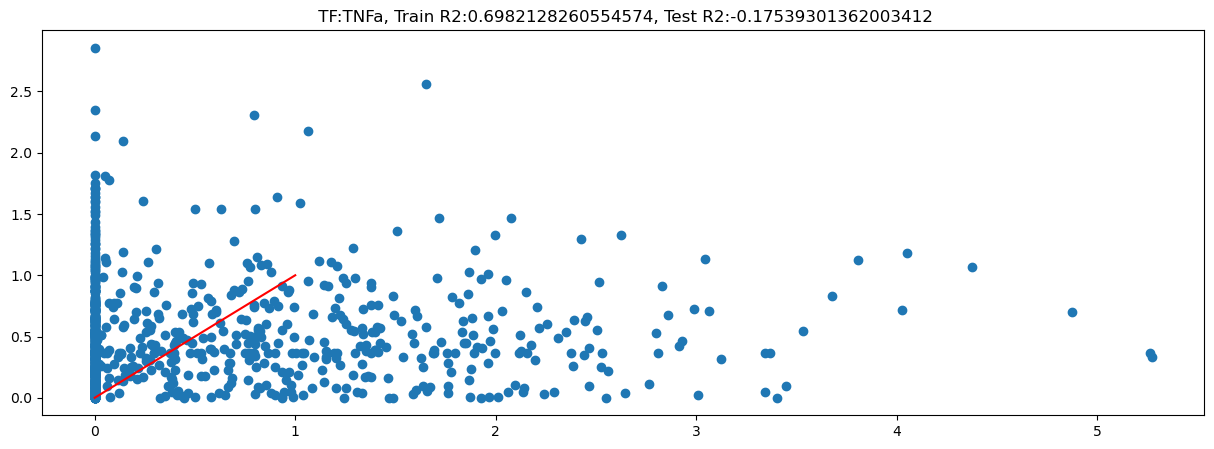

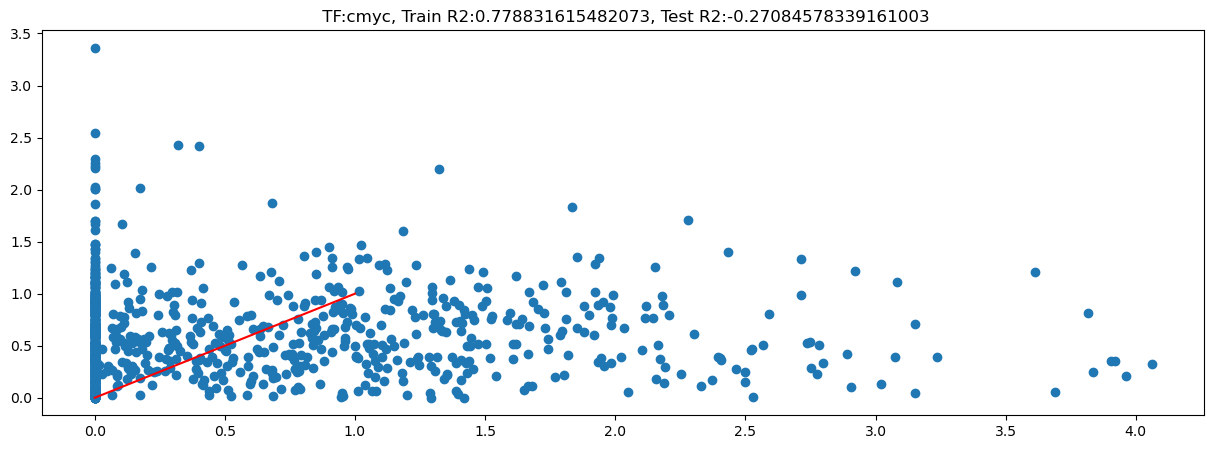

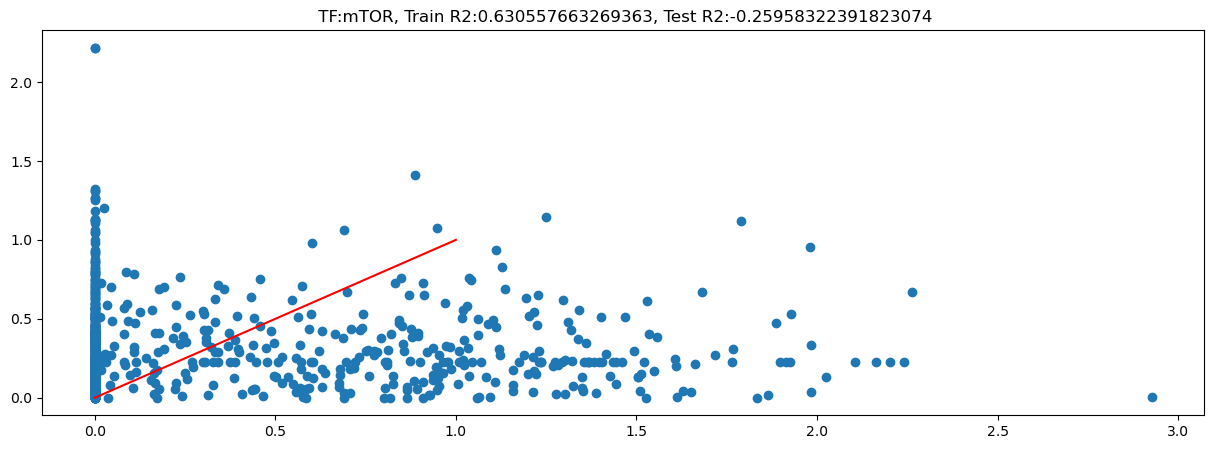

In [66]:
## Examine all the relationships by plotting true value vs predicted value

for tf in prediction_dict:
    plt.figure()
    plt.scatter(x = expression_validation_sc[tf], y = prediction_dict[tf][1])
    X = np.linspace(0,1)
    plt.plot( X, X, "r")
    plt.title( f" TF:{tf}, Train R2:{score_dict[tf][0]}, Test R2:{score_dict[tf][1]}")


In [67]:

plt.close("all")

# Reduce the overfitting

In [26]:
 # Use random TF as example, ATF1 will do nicely
    
from sklearn.model_selection import GridSearchCV

In [27]:
rf = RandomForestRegressor(random_state=2)
param_dict = {"max_depth" : [None, 1000, 500, 100], 
              "min_samples_split" : [2, 10, 50, 100],
             "min_samples_leaf" : [1, 10, 100, 500, 1000],
             "max_leaf_nodes" : [None, 3000, 1000, 500]}

grid1 = GridSearchCV(estimator=rf,
                    param_grid=param_dict,
                    scoring="r2",
                    verbose=3,
                    return_train_score=True,
                    refit=True, 
                    cv = 5)
grid2 = GridSearchCV(estimator=rf,
                    param_grid=param_dict,
                    scoring="r2",
                    verbose=3,
                    return_train_score=True,
                    refit=True, 
                    cv = 2)

In [28]:
grid1.fit(X = expression_sc[upstream_nodes_dict["ATF2"]], y = expression_sc["ATF2"])

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.355) total time=   0.5s
[CV 2/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.500, test=-0.292) total time=   0.4s
[CV 3/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.276) total time=   0.4s
[CV 4/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.533, test=-0.211) total time=   0.4s
[CV 5/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.513, test=-0.259) total time=   0.5s
[CV 1/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.317, test=-0.186) total time=   0.4s
[CV 2/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, m

[CV 2/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.007, test=0.011) total time=   0.2s
[CV 3/5] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.008, test=-

[CV 3/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.149, test=-0.045) total time=   0.3s
[CV 4/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.151, test=-0.032) total time=   0.4s
[CV 5/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.150, test=-0.035) total time=   0.4s
[CV 1/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.042) total time=   0.3s
[CV 2/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.014) total time=   0.4s
[CV 3/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.106, test=-0.030) total time=   0.3s
[CV 4/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.103, test=-0.022) 

[CV 5/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.011) total time=   0.2s
[CV 3/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.008, test=-0.006) total time=   0.2s
[CV 4/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.003) total time=   0.2s
[CV 5/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=0

[CV 2/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.095, test=-0.040) total time=   0.3s
[CV 3/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.100, test=-0.055) total time=   0.3s
[CV 4/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.104, test=-0.039) total time=   0.3s
[CV 5/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.099, test=-0.047) total time=   0.3s
[CV 1/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.076, test=-0.043) total time=   0.3s
[CV 2/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.073, test=-0.018) total time=   0.3s
[CV 3/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.075, test=-0.03

[CV 4/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.006, test=-0.002) total time=   0.2s
[CV 5/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=0.004) total time=   0.1s
[CV 2/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.008) total time=   0.1s
[CV 3/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=-0.004) total time=   0.1s
[CV 4/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, t

[CV 1/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.014, test=0.002) total

[CV 4/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=None, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.355) total time=   0.4s
[CV 2/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.500, test=-0.292) total time=   0.4s
[CV 3/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.276) total time=   0.5s
[CV 4/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.533, test=-0.211) total time=   0.4s
[CV 5/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.513, test=-0.259) tota

[CV 1/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.007, tes

[CV 2/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.146, test=-0.029) total time=   0.4s
[CV 3/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.149, test=-0.045) total time=   0.4s
[CV 4/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.151, test=-0.032) total time=   0.4s
[CV 5/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.150, test=-0.035) total time=   0.4s
[CV 1/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.042) total time=   0.3s
[CV 2/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.014) total time=   0.4s
[CV 3/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.106, test=-0.030) t

[CV 5/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.011) total time=   0.2s
[CV 3/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.008, test=-0.006) total time=   0.2s
[CV 4/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.003) total time=   0.2s
[CV 5/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=0

[CV 2/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.095, test=-0.040) total time=   0.3s
[CV 3/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.100, test=-0.055) total time=   0.3s
[CV 4/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.104, test=-0.039) total time=   0.4s
[CV 5/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.099, test=-0.047) total time=   0.3s
[CV 1/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.076, test=-0.043) total time=   0.3s
[CV 2/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.073, test=-0.018) total time=   0.3s
[CV 3/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.075, test=-0.03

[CV 3/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.005, test=-0.004) total time=   0.2s
[CV 4/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=0.004) total time=   0.1s
[CV 2/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.008) total time=   0.1s
[CV 3/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=-0.004) total time=   0.1s
[CV 4/5] END max_depth=1000, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, te

[CV 5/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=100;, score=(train=0.057, test=-0.010) total time=   0.3s
[CV 1/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.016, test=-0.012) tota

[CV 3/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=-0.004) total time=   0.1s
[CV 4/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.355) total time=   0.4s
[CV 2/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.500, test=-0.292) total time=   0.4s
[CV 3/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.276) total time=   0.4s
[CV 4/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.533, test=-0.211) tota

[CV 5/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=0.00

[CV 2/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.146, test=-0.029) total time=   0.4s
[CV 3/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.149, test=-0.045) total time=   0.3s
[CV 4/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.151, test=-0.032) total time=   0.4s
[CV 5/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.150, test=-0.035) total time=   0.4s
[CV 1/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.042) total time=   0.3s
[CV 2/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.014) total time=   0.3s
[CV 3/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.106, test=-0.030) total ti

[CV 4/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.010, test=-0.003) total time=   0.2s
[CV 5/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.011) total time=   0.2s
[CV 3/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.008, test=-0.006) total time=   0.2s
[CV 4/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.003) total time=   0.2s
[CV 5/5] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.007) t

[CV 1/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.099, test=-0.061) total time=   0.3s
[CV 2/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.095, test=-0.040) total time=   0.3s
[CV 3/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.100, test=-0.055) total time=   0.3s
[CV 4/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.104, test=-0.039) total time=   0.3s
[CV 5/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.099, test=-0.047) total time=   0.3s
[CV 1/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.076, test=-0.043) total time=   0.3s
[CV 2/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.073, test=-0.018) tota

[CV 4/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.005, test=0.003) total time=   0.2s
[CV 1/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=0.004) total time=   0.1s
[CV 2/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.008) total time=   0.1s
[CV 3/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=-0.004) total time=   0.1s
[CV 4/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=-0.002) total time=   0.2s
[CV 5/5] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.0

[CV 1/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.014, test=0.002) total time= 

[CV 3/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=-0.004) total time=   0.2s
[CV 4/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.355) total time=   0.4s
[CV 2/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.500, test=-0.292) total time=   0.5s
[CV 3/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.508, test=-0.276) total time=   0.4s
[CV 4/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.533, test=-0.211) total t

[CV 5/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=0.00

[CV 2/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.146, test=-0.029) total time=   0.4s
[CV 3/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.149, test=-0.045) total time=   0.4s
[CV 4/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.151, test=-0.032) total time=   0.4s
[CV 5/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.150, test=-0.035) total time=   0.4s
[CV 1/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.042) total time=   0.3s
[CV 2/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.102, test=-0.014) total time=   0.4s
[CV 3/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=1, min_samples_split=100;, score=(train=0.106, test=-0.030) total ti

[CV 5/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=0.002) total time=   0.2s
[CV 2/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.011) total time=   0.2s
[CV 3/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.008, test=-0.006) total time=   0.2s
[CV 4/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.003) total time=   0.2s
[CV 5/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.007, test=0.007) total time=   0.2s
[CV 1/5] END max_depth=100, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=0.002) t

[CV 2/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.095, test=-0.040) total time=   0.3s
[CV 3/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.100, test=-0.055) total time=   0.3s
[CV 4/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.104, test=-0.039) total time=   0.3s
[CV 5/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.099, test=-0.047) total time=   0.3s
[CV 1/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.076, test=-0.043) total time=   0.3s
[CV 2/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.073, test=-0.018) total time=   0.3s
[CV 3/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.075, test=-0.035) tota

[CV 5/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=0.004) total time=   0.1s
[CV 2/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.008) total time=   0.2s
[CV 3/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=-0.004) total time=   0.1s
[CV 4/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 5/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=0.005, test=0.003) total time=   0.1s
[CV 1/5] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=50;, score=(train=0.006, test=0.0

[CV 2/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.015, test=-0.015) total time=   0.2s
[CV 4/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.018, test=-0.010) total time=   0.2s
[CV 5/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.014, test=0.004) total time=   0.2s
[CV 1/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.016, test=-0.012) total time=   0.2s
[CV 2/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.014, test=0.002) total time=   0.2s
[CV 3/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.015, test=-0.015) total time=

[CV 5/5] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=100;, score=(train=0.005, test=0.003) total time=   0.1s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2),
             param_grid={'max_depth': [None, 1000, 500, 100],
                         'max_leaf_nodes': [None, 3000, 1000, 500],
                         'min_samples_leaf': [1, 10, 100, 500, 1000],
                         'min_samples_split': [2, 10, 50, 100]},
             return_train_score=True, scoring='r2', verbose=3)

In [30]:
print(grid1.best_estimator_)
print(grid1.best_score_)
print(grid1.best_params_)

RandomForestRegressor(min_samples_leaf=500, random_state=2)
0.002236473189896104
{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 500, 'min_samples_split': 2}


In [96]:
zero = expression_sc[expression_sc["ATF1"]!= 0]
grid2.fit(X = zero[upstream_nodes_dict["ATF1"]], y = zero["ATF1"])

Fitting 2 folds for each of 320 candidates, totalling 640 fits
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.824, test=-0.171) total time=   0.3s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.825, test=-0.201) total time=   0.3s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.556, test=-0.097) total time=   0.3s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.558, test=-0.116) total time=   0.2s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=50;, score=(train=0.241, test=-0.032) total time=   0.2s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=50;, score=(train=0.230, test=-0.043) total time=   0.2s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1,

[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=2;, score=(train=0.031, test=0.001) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=2;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=10;, score=(train=0.031, test=0.001) total time=   0.2s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=10;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=50;, score=(train=0.031, test=0.001) total time=   0.2s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=50;, score=(train=0.029, test=0.002) total time=   0.2s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=100;, score=(train=0.031, test=0.001

[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=100;, score=(tr

[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=10;, score=(train=0.226, test=-0.037) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=10;, score=(train=0.228, test=-0.034) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50;, score=(train=0.157, test=-0.023) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50;, score=(train=0.151, test=-0.015) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=100;, score=(train=0.112, test=-0.014) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=100;, score=(train=0.095, test=-0.001) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=2;, score=(train=0.031, test=0.0

[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0

[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=10;, score=(train=0.556, test=-0.097) total time=   0.3s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=10;, score=(train=0.558, test=-0.116) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=50;, score=(train=0.241, test=-0.032) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=50;, score=(train=0.230, test=-0.043) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=100;, score=(train=0.158, test=-0.023) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=100;, score=(train=0.141, test=-0.025) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=2;, score=(train=0.226, test=-0.037) total tim

[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.031, test=0.001) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.031, test=0.001) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=10;, score=(train=-0.000, test=-0.003

[CV 1/2] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=2;, score=(train=0.823, test=-0.171) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=2;, score=(train=0.825, test=-0.205) total time=   0.3s
[CV 1/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=10;, score=(train=0.556, test=-0.097) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=10;, score=(train=0.558, test=-0.116) total time=   0.2s
[CV 1/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=50;, score=(train=0.241, test=-0.032) tot

[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=100;, score=(train=0.095, test=-0.001) total time=   0.2s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.031, test=0.001) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.031, test=0.001) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.029, test=0.002) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=50;, score=(train=0.031, test=0.001) total time=   0.2s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=50;, score=(train=0.029, test=0.002) total time= 

[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.00

[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=2;, score=(train=0.228, test=-0.034) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.226, test=-0.037) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.228, test=-0.034) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.157, test=-0.023) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.151, test=-0.015) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=100;, score=(train=0.112, test=-0.014) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=100;, score=(train=0.095, test=-0.001) tot

[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=2),
             param_grid={'max_depth': [None, 1000, 500, 100],
                         'max_leaf_nodes': [None, 3000, 1000, 500],
                         'min_samples_leaf': [1, 10, 100, 500, 1000],
                         'min_samples_split': [2, 10, 50, 100]},
             return_train_score=True, scoring='r2', verbose=3)

In [99]:
print(grid2.best_estimator_)
print(grid2.best_score_)
print(grid2.best_params_)

RandomForestRegressor(min_samples_leaf=100, random_state=2)
0.0014694960046278682
{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 100, 'min_samples_split': 2}


try with another TF for comparison

In [88]:
 # Use random TF as example, ATF1 will do nicely
    
from sklearn.model_selection import GridSearchCV

In [57]:
lr = LinearRegression()
param_dict = {
              "C" : [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]}

grid3 = GridSearchCV(estimator=lr,
                    param_grid=param_dict,
                    scoring="r2",
                    verbose=3,
                    return_train_score=True,
                    refit=True, 
                    cv = 5)
grid4 = GridSearchCV(estimator=rf,
                    param_grid=param_dict,
                    scoring="r2",
                    verbose=3,
                    return_train_score=True,
                    refit=True, 
                    cv = 2)

In [58]:
grid3.fit(X = expression_sc[upstream_nodes_dict["ATF1"]], y = expression_sc["ATF1"])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


ValueError: Invalid parameter 'C' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'].

In [59]:
print(grid3.best_estimator_)
print(grid3.best_score_)
print(grid3.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [107]:
zero = expression_sc[expression_sc["JUN"]!= 0]
grid4.fit(X = zero[upstream_nodes_dict["JUN"]], y = zero["JUN"])

Fitting 2 folds for each of 320 candidates, totalling 640 fits
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.834, test=-0.116) total time=   0.9s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=0.840, test=-0.131) total time=   0.9s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.619, test=-0.083) total time=   0.7s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.625, test=-0.090) total time=   0.8s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=50;, score=(train=0.267, test=-0.038) total time=   0.6s
[CV 2/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=50;, score=(train=0.270, test=-0.044) total time=   0.7s
[CV 1/2] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1,

[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=2;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=2;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=10;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=10;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=50;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=50;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=None, max_leaf_nodes=3000, min_samples_leaf=100, min_samples_split=100;, score=(train=0.042, test

[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=None, max_leaf_nodes=1000, min_samples_leaf=1000, min_samples_split=100;, score=(tr

[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=10;, score=(train=0.294, test=-0.052) total time=   0.6s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=10;, score=(train=0.303, test=-0.056) total time=   0.6s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50;, score=(train=0.199, test=-0.036) total time=   0.5s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50;, score=(train=0.206, test=-0.040) total time=   0.6s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=100;, score=(train=0.137, test=-0.027) total time=   0.5s
[CV 2/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=100;, score=(train=0.138, test=-0.030) total time=   0.5s
[CV 1/2] END max_depth=1000, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=2;, score=(train=0.042, test=-0.

[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=10;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=1000, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000,

[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=10;, score=(train=0.625, test=-0.091) total time=   0.8s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=50;, score=(train=0.267, test=-0.038) total time=   0.6s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=50;, score=(train=0.270, test=-0.044) total time=   0.7s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=100;, score=(train=0.168, test=-0.028) total time=   0.6s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=100;, score=(train=0.170, test=-0.031) total time=   0.6s
[CV 1/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=2;, score=(train=0.294, test=-0.052) total time=   0.6s
[CV 2/2] END max_depth=1000, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=2;, score=(train=0.303, test=-0.056) total tim

[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=100;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=500, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=10;, score=(train=0.010, test=-0.00

[CV 2/2] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=500, max_leaf_nodes=3000, min_samples_leaf=1000, min_samples_split=100;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=2;, score=(train=0.831, test=-0.117) total time=   0.8s
[CV 2/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=2;, score=(train=0.838, test=-0.127) total time=   0.9s
[CV 1/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=10;, score=(train=0.619, test=-0.083) total time=   0.7s
[CV 2/2] END max_depth=500, max_leaf_nodes=1000, min_samples_leaf=1, min_samples_split=10;, score=(train=0.625, test=-0.091)

[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=100;, score=(train=0.137, test=-0.027) total time=   0.5s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=10, min_samples_split=100;, score=(train=0.138, test=-0.030) total time=   0.5s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.042, test=-0.013) total time=   0.3s
[CV 2/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=10;, score=(train=0.043, test=-0.009) total time=   0.3s
[CV 1/2] END max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=50;, score=(train=0.042, test=-0.013) total 

[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=2;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=10;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 1/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000, test=-0.003) total time=   0.1s
[CV 2/2] END max_depth=100, max_leaf_nodes=None, min_samples_leaf=1000, min_samples_split=50;, score=(train=-0.000,

[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=2;, score=(train=0.294, test=-0.052) total time=   0.6s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=2;, score=(train=0.303, test=-0.056) total time=   0.6s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.294, test=-0.052) total time=   0.6s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=10;, score=(train=0.303, test=-0.056) total time=   0.6s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.199, test=-0.036) total time=   0.5s
[CV 2/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=50;, score=(train=0.206, test=-0.040) total time=   0.6s
[CV 1/2] END max_depth=100, max_leaf_nodes=1000, min_samples_leaf=10, min_samples_split=100;, score=(train=0.137, test=-0.027) total

[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=2;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=10;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=10;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=50;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=50;, score=(train=0.009, test=-0.003) total time=   0.2s
[CV 1/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=100;, score=(train=0.010, test=-0.004) total time=   0.2s
[CV 2/2] END max_depth=100, max_leaf_nodes=500, min_samples_leaf=500, min_samples_split=100;, score=(train=0.009, test=-0.003) tot

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=2),
             param_grid={'max_depth': [None, 1000, 500, 100],
                         'max_leaf_nodes': [None, 3000, 1000, 500],
                         'min_samples_leaf': [1, 10, 100, 500, 1000],
                         'min_samples_split': [2, 10, 50, 100]},
             return_train_score=True, scoring='r2', verbose=3)

In [108]:
print(grid4.best_estimator_)
print(grid4.best_score_)
print(grid4.best_params_)

RandomForestRegressor(min_samples_leaf=1000, random_state=2)
-0.003312592992618879
{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1000, 'min_samples_split': 2}


# Remove all the zero values of the TF and then refit and replot

['CD3z', 'MAPK', 'p38']

ATF1
ATF2
BCL3
CEBPB
CEBPZ
E2F4
ELK1
ELK4
ESR1
ETS1
FOS
FOSL1
FOSL2
GABPA
GATA1
GATA1 could not be fit
Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.
GATA2
GATA2 could not be fit
Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.
HSF1
IRF3
JUN
JUND
MEF2A
MEF2C
MEF2C could not be fit
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
MYC
NANOG
NANOG could not be fit
Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.
NFAT


/tmp/ipykernel_360594/2787181314.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


NFATC1
REST
RXRA
SP1
STAT1
STAT3
STAT5
TAL1
AP1
AP1 could not be fit
'AP1'
Bcl2


/home/ubuntu/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


BclXL
GADS
IFNG
IL2
IL6
TNFa
cmyc
mTOR


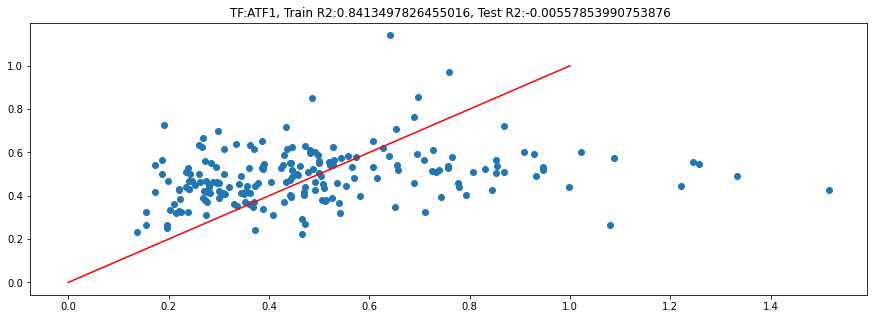

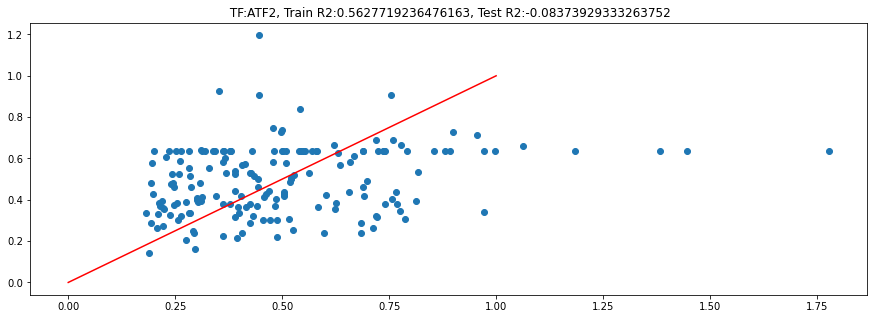

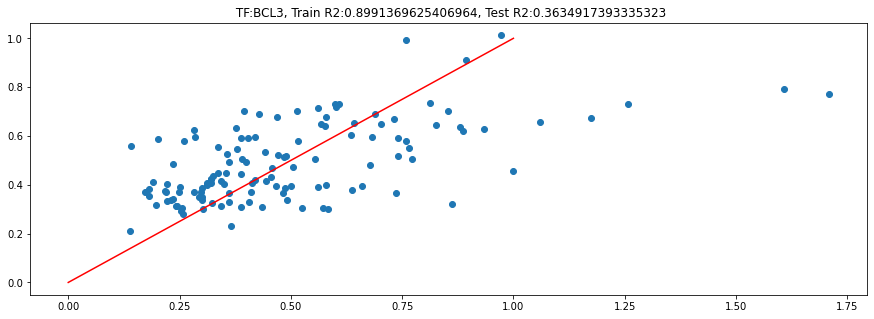

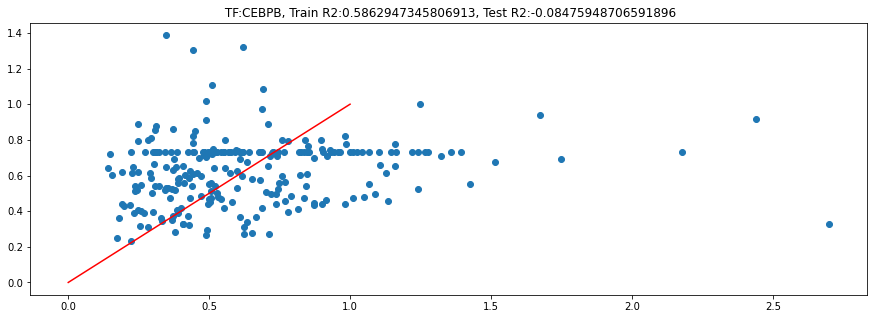

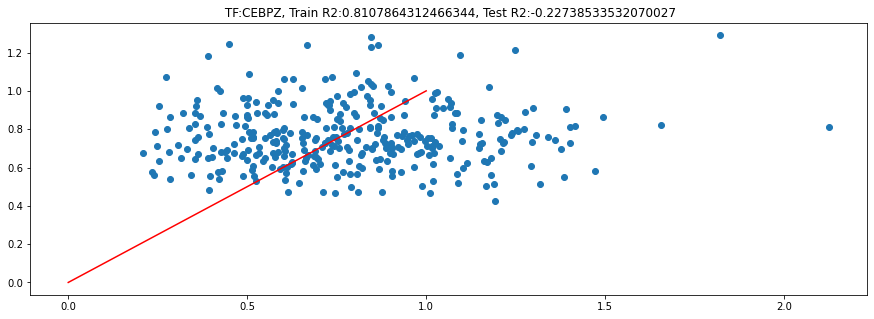

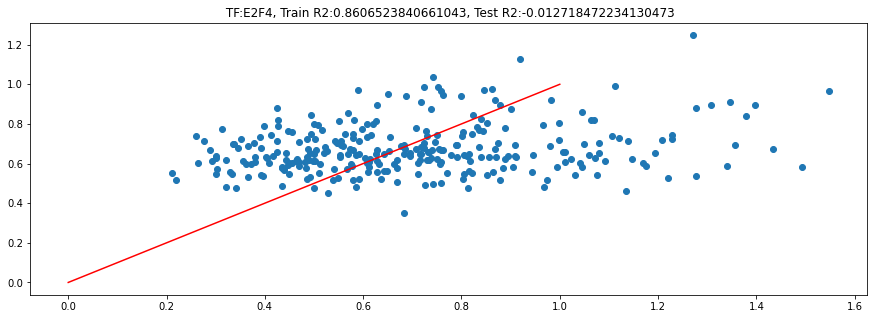

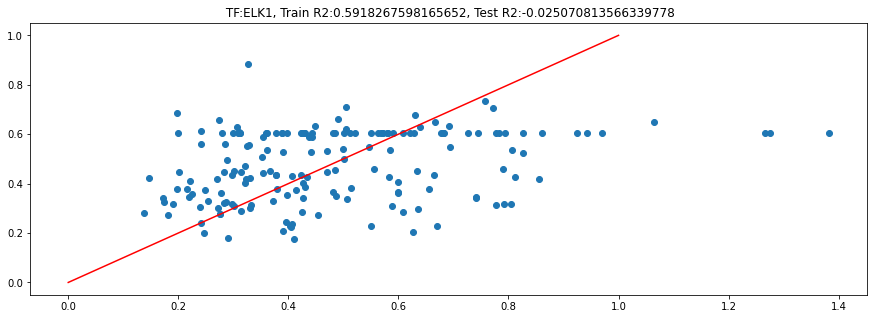

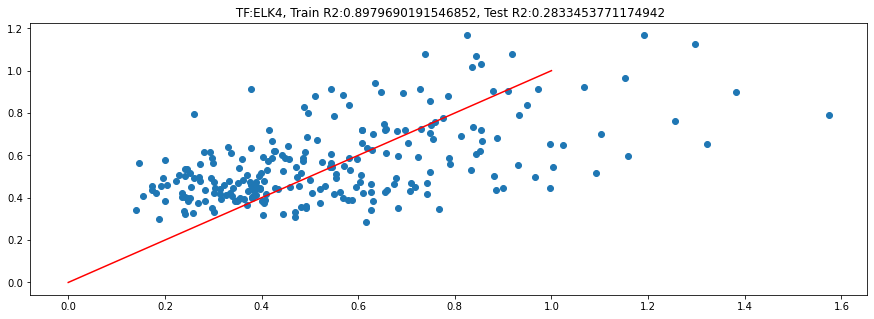

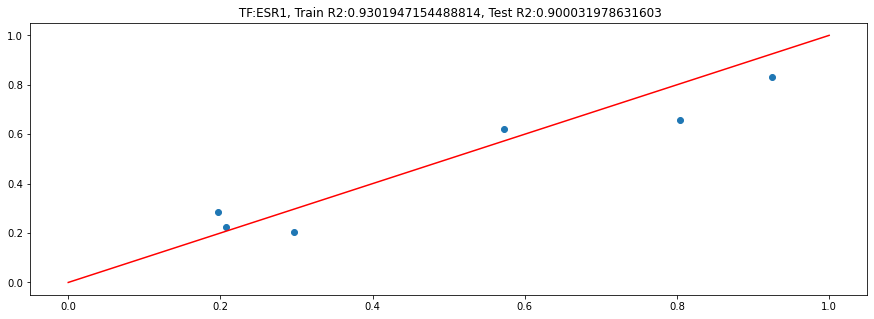

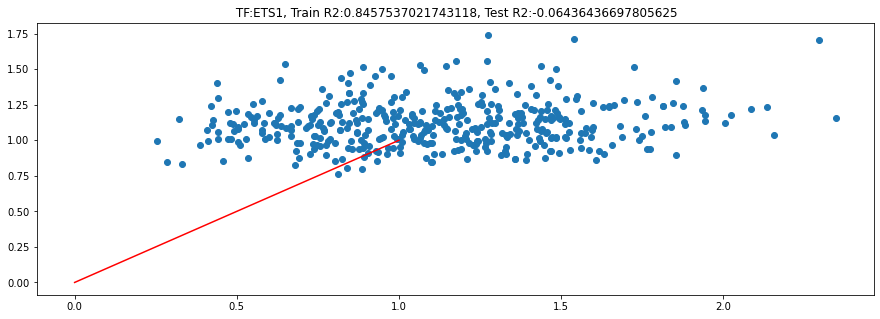

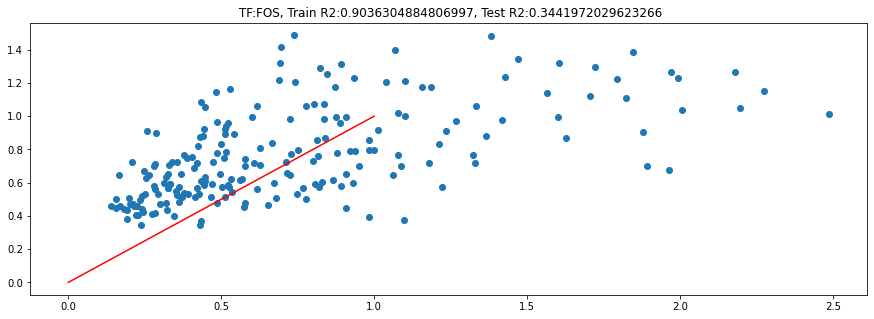

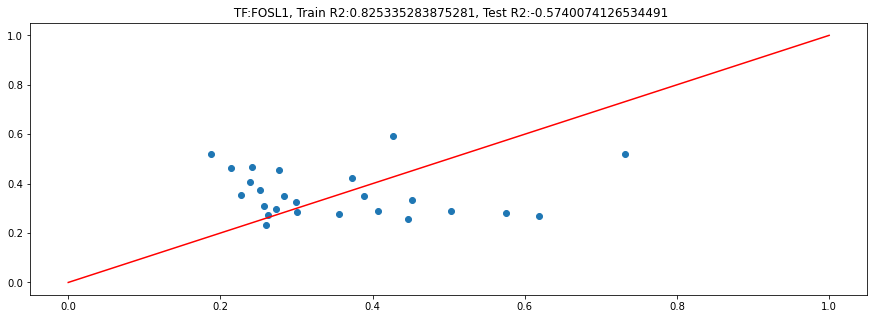

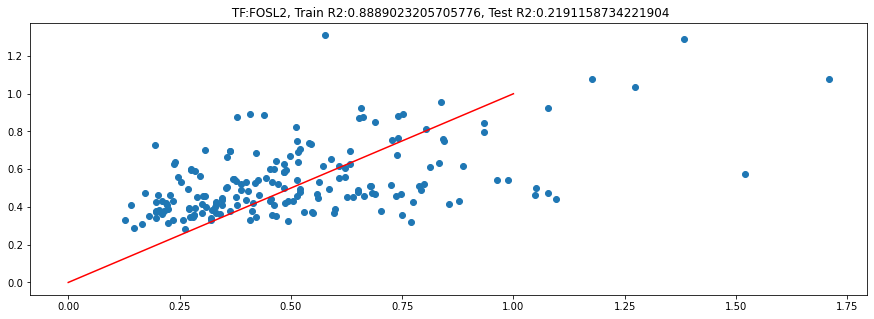

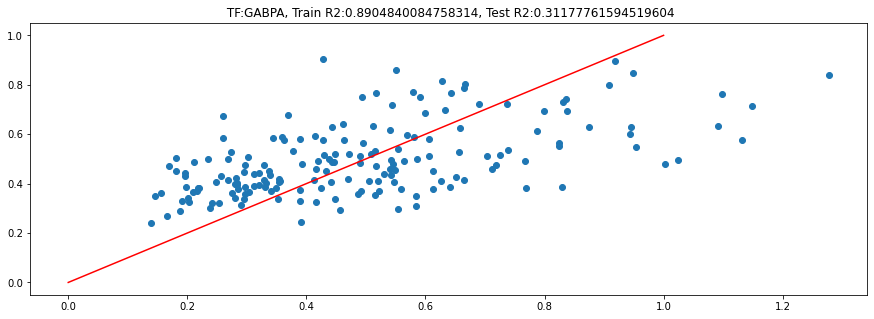

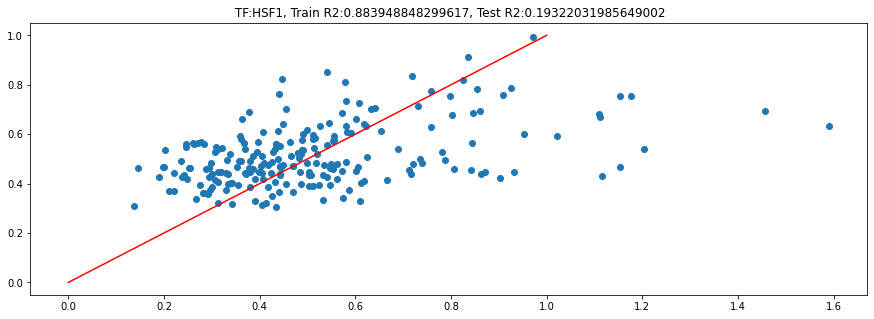

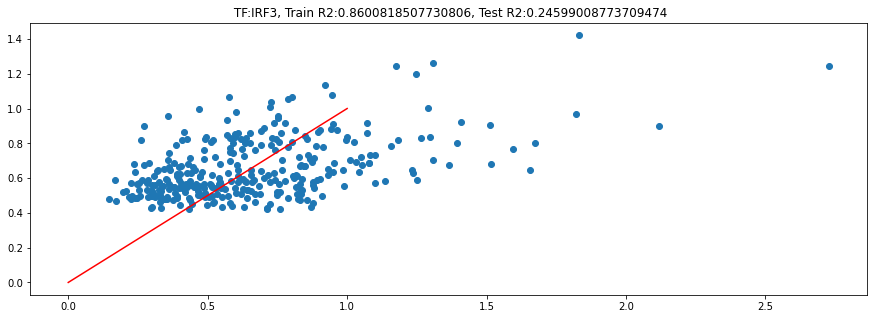

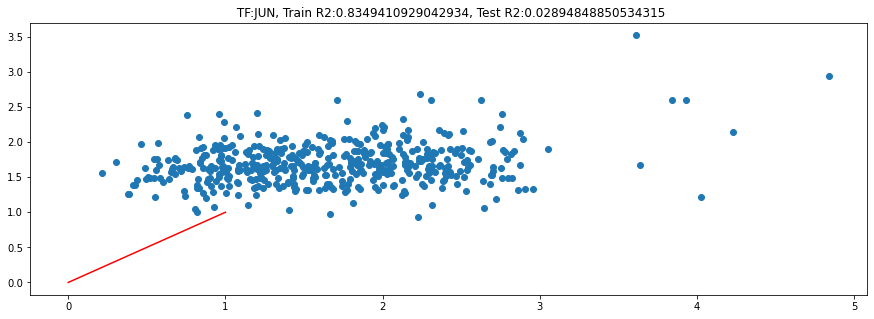

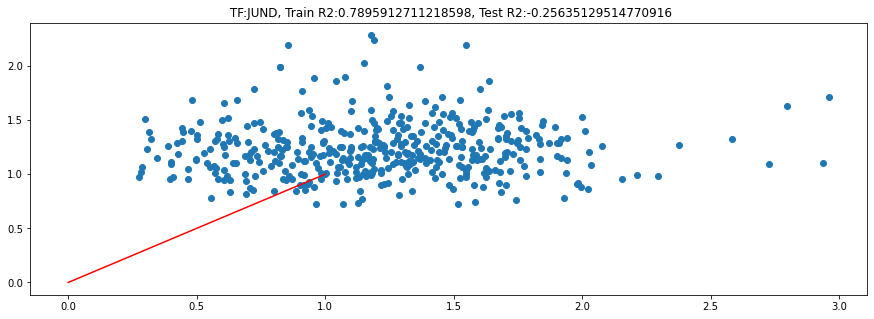

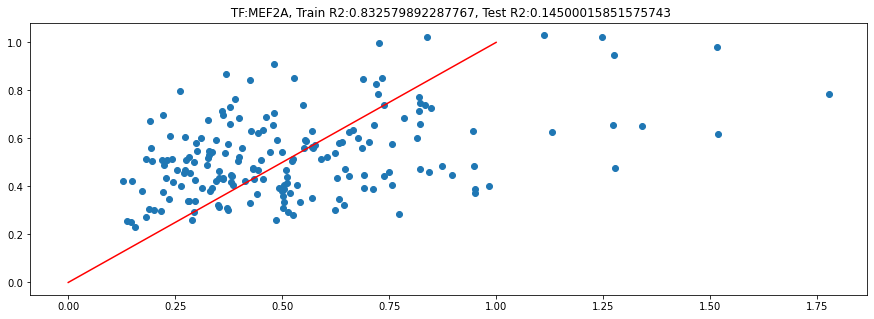

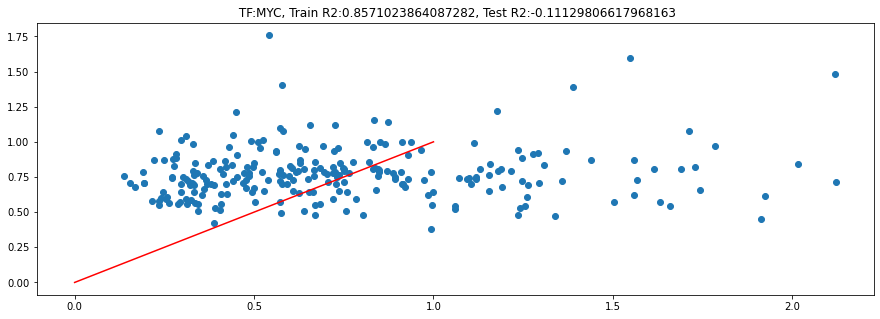

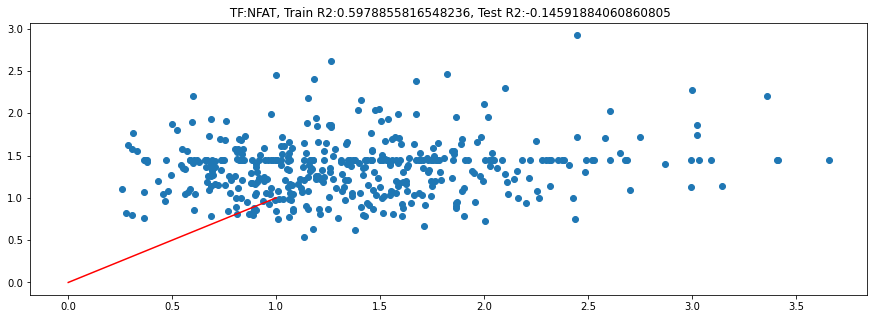

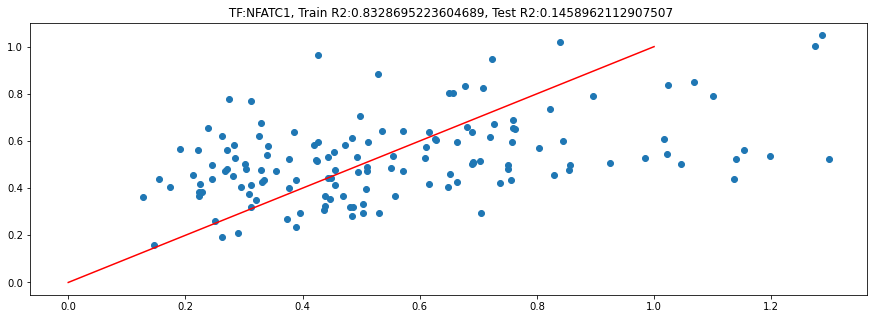

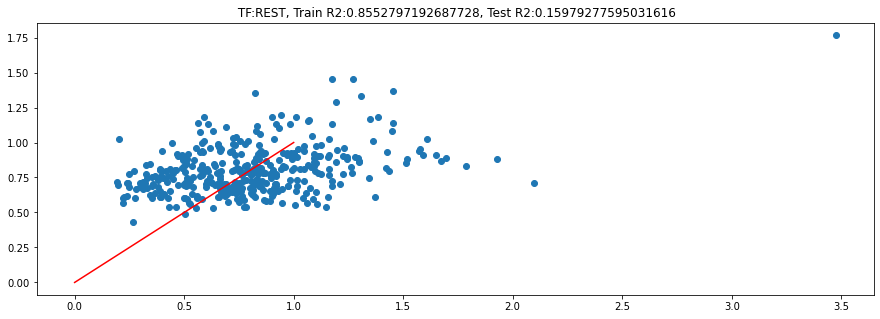

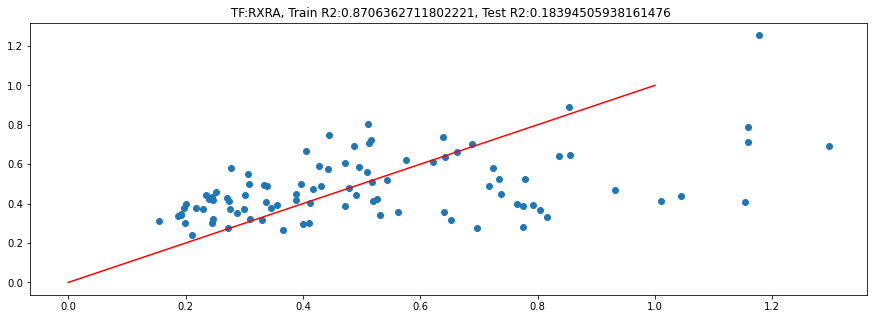

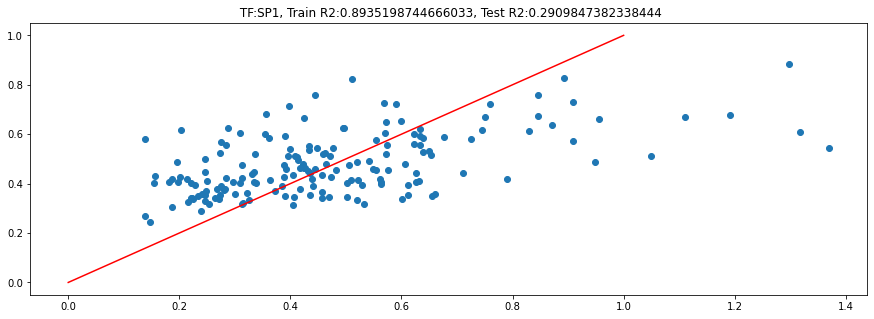

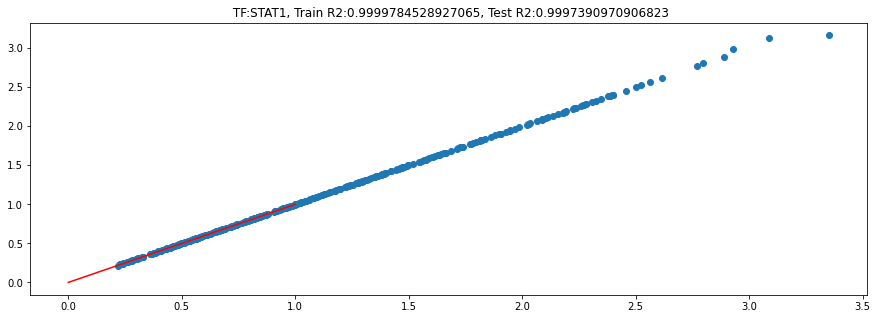

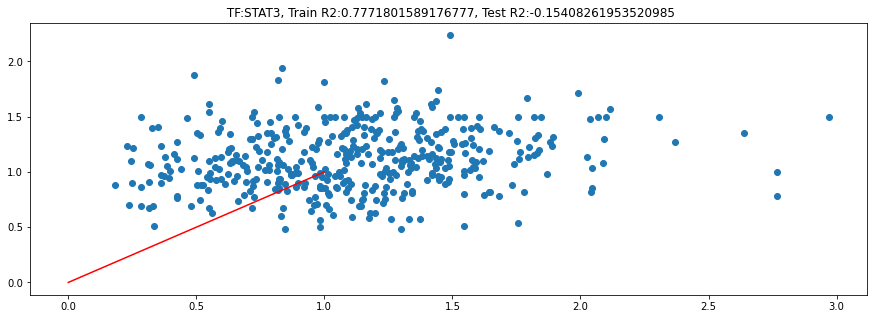

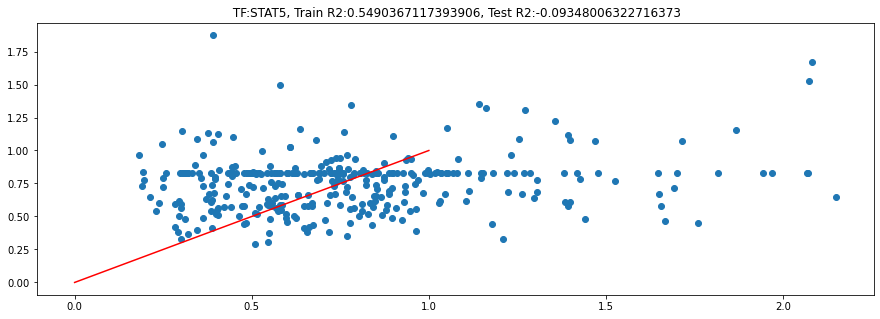

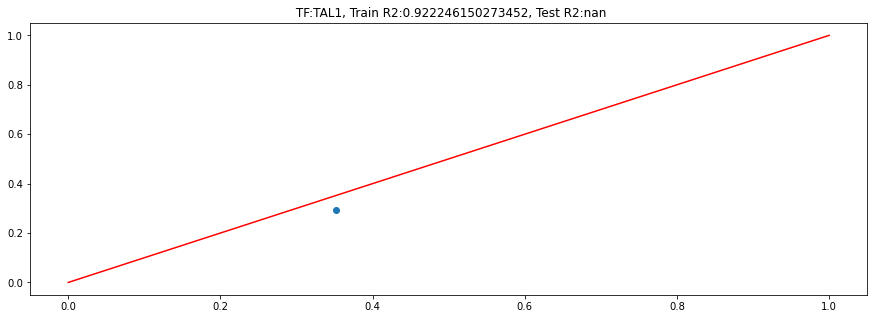

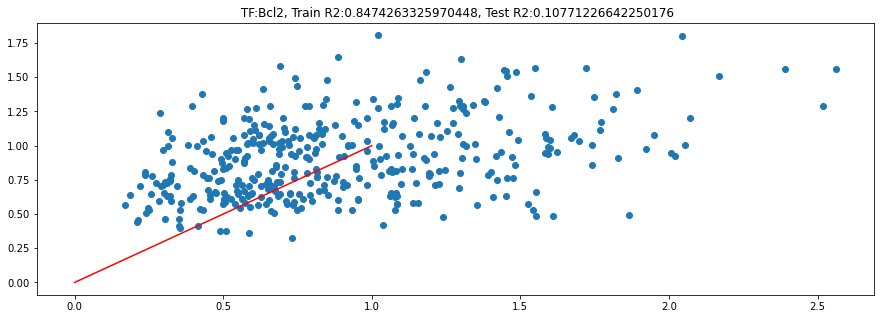

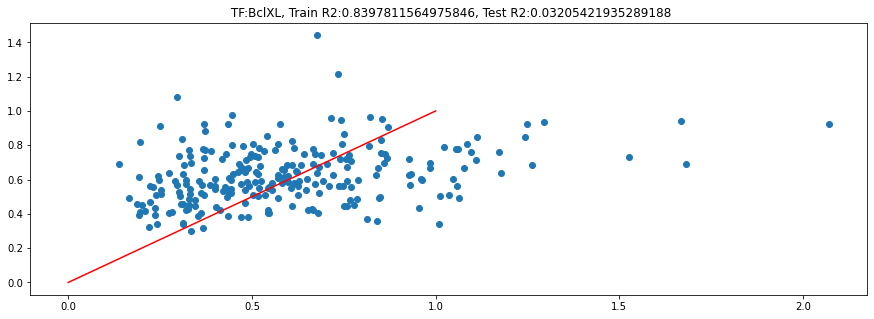

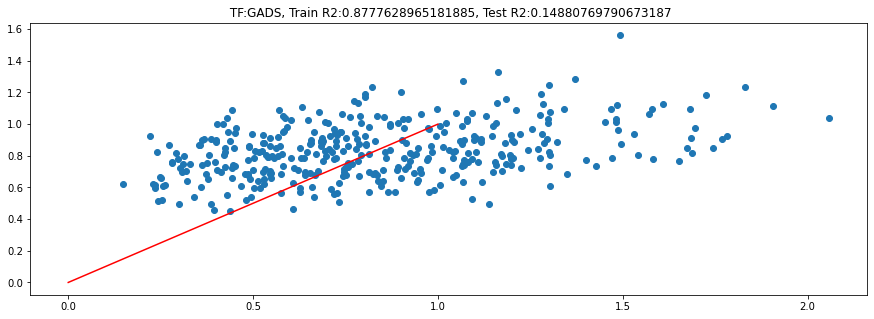

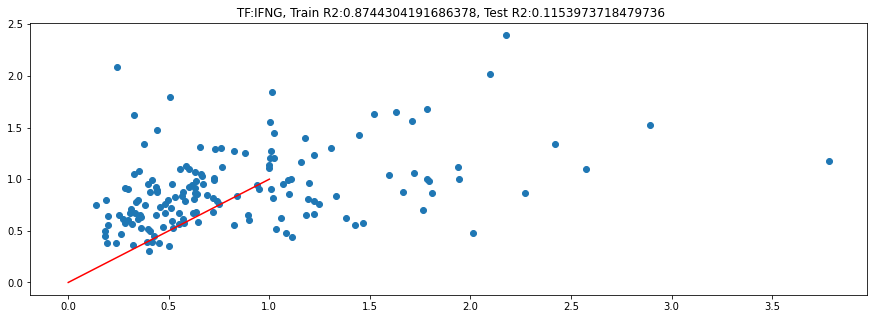

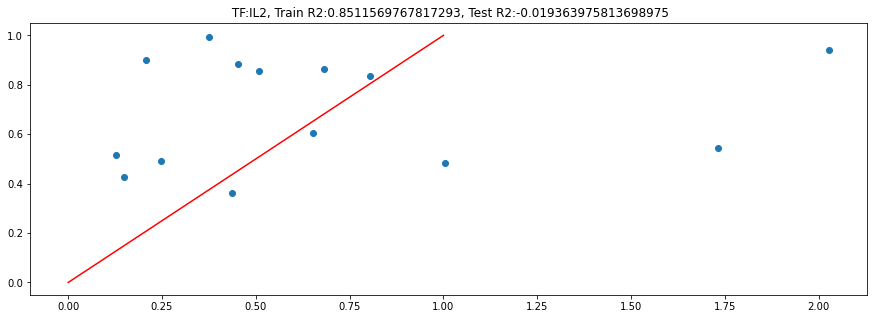

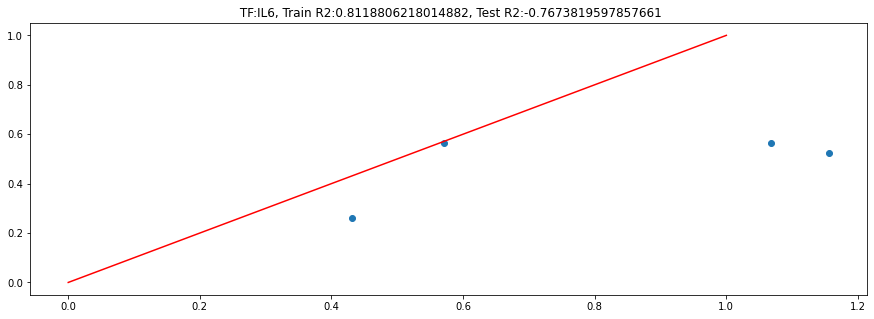

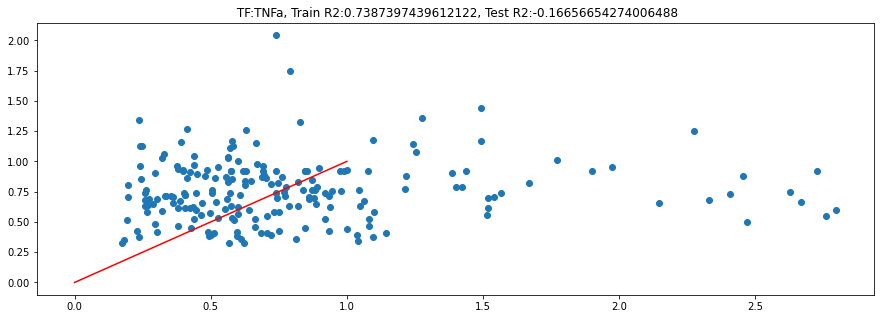

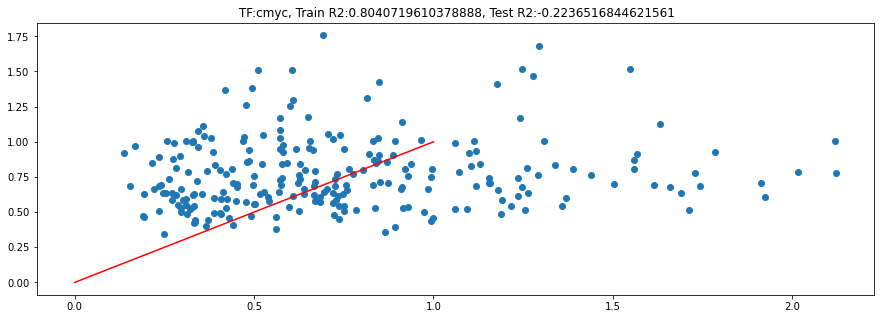

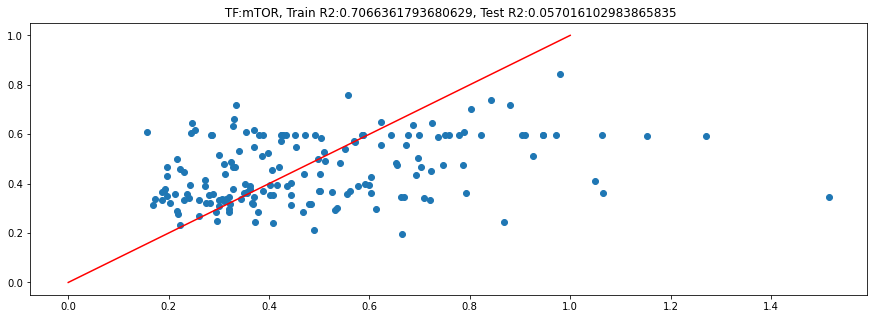

In [36]:


## Fit a random forest to each TF and create a dictionary to save the results
rf_dict = {}
unfit = []
for tf in upstream_nodes_dict:
    print(tf)
    rf = sklearn.ensemble.RandomForestRegressor(random_state=2)
    parents = upstream_nodes_dict[tf]

    try:
        nonzeroTF_train = expression_training_sc[expression_training_sc[tf]!= 0]
        nonzeroTF_test = expression_validation_sc[expression_validation_sc[tf]!= 0]
        rf.fit(X = nonzeroTF_train[upstream_nodes_dict[tf]],
               y = nonzeroTF_train[tf])
        rf_dict[tf] = rf
        ## For each model that was fit: predict and assess fit on the training and validation set
        ypred_test = rf.predict(nonzeroTF_test[parents])
        ypred_train = rf.predict(nonzeroTF_train[parents])

    

        score_train = sklearn.metrics.r2_score(y_true=nonzeroTF_train[tf],
                                             y_pred = ypred_train)
        score_test = sklearn.metrics.r2_score(y_true=nonzeroTF_test[tf],
                                             y_pred = ypred_test)


        plt.figure()
        plt.scatter(x = nonzeroTF_test[tf], y = ypred_test)
        X = np.linspace(0,1)
        plt.plot( X, X, "r")
        plt.title( f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")


        
    except BaseException as e:
        print(f"{tf} could not be fit")
        print(e)
        unfit.append(tf)
        
    


In [37]:
plt.close("all")

In [38]:
# same thing with a linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [40]:
scaled_data_train = expression_training_sc.copy()
scaled_data_test = expression_validation_sc.copy()
std = sklearn.preprocessing.StandardScaler()
std.fit_transform(scaled_data_train)
std.transform(scaled_data_test)

## Fit a random forest to each TF and create a dictionary to save the results
rf_dict = {}
unfit = []
for tf in upstream_nodes_dict:
    print(tf)
    rf = LinearRegression(fit_intercept=True)
    parents = upstream_nodes_dict[tf]

    try:
        nonzeroTF_train = scaled_data_train[scaled_data_train[tf]!= 0]
        nonzeroTF_test = scaled_data_test[scaled_data_test[tf]!= 0]
        rf.fit(X = nonzeroTF_train[upstream_nodes_dict[tf]],
               y = nonzeroTF_train[tf])
        rf_dict[tf] = rf
        ## For each model that was fit: predict and assess fit on the training and validation set
        ypred_test = rf.predict(nonzeroTF_test[parents])
        ypred_train = rf.predict(nonzeroTF_train[parents])

    

        score_train = sklearn.metrics.r2_score(y_true=nonzeroTF_train[tf],
                                             y_pred = ypred_train)
        score_test = sklearn.metrics.r2_score(y_true=nonzeroTF_test[tf],
                                             y_pred = ypred_test)


        plt.figure()
        plt.scatter(x = nonzeroTF_test[tf], y = ypred_test)
        X = np.linspace(0,1)
        plt.plot( X, X, "r")
        plt.title( f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")


        
    except BaseException as e:
        print(f"{tf} could not be fit")
        print(e)
        unfit.append(tf)
        
    



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


ValueError: could not convert string to float: 'hCD40_hCD28'

In [ ]:
G_G